In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyqg
from time import time
import os
import glob
from pyqg_generative.models.ols_model import OLSModel
from pyqg_generative.models.mean_var_model import MeanVarModel
from pyqg_generative.models.cgan_regression import CGANRegression
from pyqg_generative.tools.stochastic_pyqg import stochastic_QGModel
from pyqg_generative.tools.spectral_tools import spectrum
from pyqg_generative.tools.comparison_tools import *
import pyqg_parameterization_benchmarks as ppb
import json
%load_ext autoreload
%autoreload 3

/ext3/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pp2681/pyqg_experiments/pyqg_subgrid_experiments/__init__.py:19: UserWarning: Unable to load differentiable_parameterizations, install autograd if you want to use these
  warnings.warn("Unable to load differentiable_parameterizations, install autograd if you want to use these")


In [9]:
for folder in folder_iterator(return_blowup=True):
    nfiles = len(glob.glob(os.path.join(folder, '*.nc')))
    if nfiles < 10:
        print('Blow up experiment:', folder)
        print(nfiles)

Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/OLSModel/eddy-constant-0
7
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/CGANRegression/eddy-AR1-12
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/CGANRegression/eddy-AR1-24
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/CGANRegression/eddy-AR1-36
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/CGANRegression/eddy-AR1-48
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/CGANRegression/eddy-constant-0
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-32/MeanVarModel/eddy-AR1-12
0
Blow up experiment: /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-32/MeanVarModel/eddy-AR1

In [66]:
highres = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/*.nc', combine='nested', concat_dim='run').load()
lowres = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc', combine='nested', concat_dim='run').load()

In [67]:
ds = coarsegrain_reference_dataset(highres, 64, 'Operator1')

var =  q
var =  u
var =  v
var =  psi


In [86]:
model = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-constant-0/*.nc', combine='nested', concat_dim='run')

In [122]:
%time ppb.diagnostic_similarities(model, ds, lowres, T=128)

CPU times: user 1min 10s, sys: 5.16 s, total: 1min 15s
Wall time: 1min 15s


{'distrib_diff_q1': 0.858958848737749,
 'distrib_diff_q2': 0.6829852218793004,
 'distrib_diff_u1': 0.8365561707176606,
 'distrib_diff_u2': 0.8359515205384592,
 'distrib_diff_v1': 0.8239561245227166,
 'distrib_diff_v2': 0.771637605692762,
 'distrib_diff_KE1': 0.8146259291083773,
 'distrib_diff_KE2': 0.7922537680920104,
 'distrib_diff_Ens1': 0.4273043973838644,
 'distrib_diff_Ens2': 0.9046362065639878,
 'spectral_diff_KEspec1': 0.7022520926440158,
 'spectral_diff_KEspec2': 0.7462702366351059,
 'spectral_diff_KEflux': 0.67189171244816,
 'spectral_diff_APEflux': 0.6747191576393875,
 'spectral_diff_APEgenspec': 0.7034482416054892,
 'spectral_diff_KEfrictionspec': 0.7462701065564776}

In [123]:
%time ppb.diagnostic_similarities(model, highres, lowres, T=1)

CPU times: user 4.36 s, sys: 187 ms, total: 4.55 s
Wall time: 4.35 s


{'distrib_diff_q1': 0.4782988103506248,
 'distrib_diff_q2': 0.5478571219381726,
 'distrib_diff_u1': 0.6549958889167478,
 'distrib_diff_u2': 0.5696289673682191,
 'distrib_diff_v1': 0.6647169852138799,
 'distrib_diff_v2': 0.6201911718994578,
 'distrib_diff_KE1': 0.6833885827469166,
 'distrib_diff_KE2': 0.5772909989774108,
 'distrib_diff_Ens1': 0.25183050288287756,
 'distrib_diff_Ens2': 0.615745445766283,
 'spectral_diff_KEspec1': 0.7022520686893807,
 'spectral_diff_KEspec2': 0.7462702061045448,
 'spectral_diff_KEflux': 0.6718916355424516,
 'spectral_diff_APEflux': 0.6747191837748199,
 'spectral_diff_APEgenspec': 0.7034481553888974,
 'spectral_diff_KEfrictionspec': 0.7462701927170194}

# Coarsegraining relative to all present filters

In [9]:
configuration = 'jet'

In [10]:
highres = xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/{configuration}/reference_256/[0-9].nc', combine='nested', concat_dim='run').load()

In [11]:
for resolution in [32, 48, 64, 96]:
    for operator in ['Operator1', 'Operator2']:
        file = f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/{configuration}/reference_256/'+operator+'-'+str(resolution)+'.nc'
        print(file)
        %time coarsegrain_reference_dataset(highres, resolution, operator).to_netcdf(file)

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator1-32.nc
CPU times: user 1min 16s, sys: 0 ns, total: 1min 16s
Wall time: 1min 17s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator2-32.nc
CPU times: user 1min 16s, sys: 0 ns, total: 1min 16s
Wall time: 1min 17s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator1-48.nc
CPU times: user 1min 26s, sys: 602 ms, total: 1min 27s
Wall time: 1min 28s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator2-48.nc
CPU times: user 1min 27s, sys: 656 ms, total: 1min 27s
Wall time: 1min 28s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator1-64.nc
CPU times: user 1min 32s, sys: 999 ms, total: 1min 33s
Wall time: 1min 34s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator2-64.nc
CPU times: user 1min 35s, sys: 967 ms, total: 1min 36s
Wall time: 1min 36s
/scratch

In [2]:
similarity = {}
for model_folder, reference_folder, baseline_folder, key in folder_iterator(return_reference=True):
    model = xr.open_mfdataset(os.path.join(model_folder, '*.nc'), combine='nested', concat_dim='run').load()
    reference = xr.open_dataset(reference_folder).load()
    baseline = xr.open_mfdataset(baseline_folder, combine='nested', concat_dim='run').load()
    print(model_folder, reference_folder, baseline_folder, key, sep='\n')
    %time similarity[key] = ppb.diagnostic_similarities(model, reference, baseline, T=128)

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-0
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/*.nc
Operator1-48/OLSModel/eddy-constant-0
CPU times: user 39.6 s, sys: 2.2 s, total: 41.8 s
Wall time: 41.9 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/*.nc
Operator1-48/OLSModel/eddy-constant-12
CPU times: user 39.2 s, sys: 2.29 s, total: 41.5 s
Wall time: 41.6 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
/scratch/pp2681/pyqg_generative/Reference-

CPU times: user 39.6 s, sys: 1.11 s, total: 40.7 s
Wall time: 40.8 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/OLSModel/eddy-constant-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-48.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/*.nc
Operator2-48/OLSModel/eddy-constant-36
CPU times: user 39.7 s, sys: 546 ms, total: 40.3 s
Wall time: 40.4 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/OLSModel/eddy-constant-48
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-48.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/*.nc
Operator2-48/OLSModel/eddy-constant-48
CPU times: user 40 s, sys: 1.28 s, total: 41.3 s
Wall time: 41.5 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/MeanVarModel/eddy-AR1-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/ref

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/OLSModel/eddy-constant-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator1-64/OLSModel/eddy-constant-12
CPU times: user 1min 19s, sys: 3.25 s, total: 1min 22s
Wall time: 1min 23s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/OLSModel/eddy-constant-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator1-64/OLSModel/eddy-constant-24
CPU times: user 1min 17s, sys: 2.09 s, total: 1min 19s
Wall time: 1min 20s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/OLSModel/eddy-constant-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc
/scratch/pp2681/pyqg_genera

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-constant-48
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator1-64/CGANRegression/eddy-constant-48
CPU times: user 1min 14s, sys: 3.04 s, total: 1min 17s
Wall time: 1min 17s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/OLSModel/eddy-constant-0
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator2-64/OLSModel/eddy-constant-0
CPU times: user 1min 13s, sys: 4.29 s, total: 1min 17s
Wall time: 1min 18s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/OLSModel/eddy-constant-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
/scratch/pp2681/p

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CGANRegression/eddy-constant-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator2-64/CGANRegression/eddy-constant-24
CPU times: user 1min 9s, sys: 4.37 s, total: 1min 13s
Wall time: 1min 14s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CGANRegression/eddy-constant-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/*.nc
Operator2-64/CGANRegression/eddy-constant-36
CPU times: user 1min 10s, sys: 2.03 s, total: 1min 12s
Wall time: 1min 12s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CGANRegression/eddy-constant-48
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.n

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/OLSModel/eddy-constant-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-96.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_96/*.nc
Operator2-96/OLSModel/eddy-constant-12
CPU times: user 3min 2s, sys: 10.3 s, total: 3min 12s
Wall time: 3min 13s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/OLSModel/eddy-constant-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-96.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_96/*.nc
Operator2-96/OLSModel/eddy-constant-24
CPU times: user 3min 2s, sys: 10.6 s, total: 3min 13s
Wall time: 3min 14s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/OLSModel/eddy-constant-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-96.nc
/scratch/pp2681/pyqg_generati

In [5]:
#with open('similarity.json', 'w') as file:
#    json.dump(similarity, file)

In [3]:
difference = {}
for model_folder, reference_folder, baseline_folder, key in folder_iterator(return_reference=True):
    model = xr.open_mfdataset(os.path.join(model_folder, '*.nc'), combine='nested', concat_dim='run').load()
    reference = xr.open_dataset(reference_folder).load()
    #baseline = xr.open_mfdataset(baseline_folder, combine='nested', concat_dim='run').load()
    print(model_folder, reference_folder, key, sep='\n')
    %time difference[key],_,_ = ppb.diagnostic_differences_Perezhogin(model, reference, T=128)

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/MeanVarModel/eddy-AR1-12
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-32.nc
Operator1-32/MeanVarModel/eddy-AR1-12
CPU times: user 7.92 s, sys: 493 ms, total: 8.41 s
Wall time: 8.45 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/MeanVarModel/eddy-AR1-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-32.nc
Operator1-32/MeanVarModel/eddy-AR1-24
CPU times: user 7.97 s, sys: 207 ms, total: 8.18 s
Wall time: 8.23 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/MeanVarModel/eddy-AR1-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-32.nc
Operator1-32/MeanVarModel/eddy-AR1-36
CPU times: user 8.07 s, sys: 41.6 ms, total: 8.12 s
Wall time: 8.16 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-32/MeanVarModel/eddy-A

KeyboardInterrupt: 

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/eddy-AR1-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Operator1-48/CGANRegression/eddy-AR1-36
CPU times: user 20.1 s, sys: 1.1 s, total: 21.2 s
Wall time: 21.4 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/eddy-AR1-48
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Operator1-48/CGANRegression/eddy-AR1-48
CPU times: user 20.1 s, sys: 884 ms, total: 21 s
Wall time: 21.1 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/eddy-constant-0
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Operator1-48/CGANRegression/eddy-constant-0
CPU times: user 20.3 s, sys: 378 ms, total: 20.7 s
Wall time: 20.8 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/OLS

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/MeanVarModel/eddy-AR1-24
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
Operator2-64/MeanVarModel/eddy-AR1-24
CPU times: user 37.4 s, sys: 2.19 s, total: 39.6 s
Wall time: 39.9 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/MeanVarModel/eddy-AR1-36
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
Operator2-64/MeanVarModel/eddy-AR1-36
CPU times: user 38.2 s, sys: 2.13 s, total: 40.4 s
Wall time: 40.6 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/MeanVarModel/eddy-AR1-48
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-64.nc
Operator2-64/MeanVarModel/eddy-AR1-48
CPU times: user 37.3 s, sys: 2.24 s, total: 39.6 s
Wall time: 39.8 s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/MeanVarModel/eddy-co

CPU times: user 1min 30s, sys: 6.17 s, total: 1min 37s
Wall time: 1min 37s
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/CGANRegression/eddy-constant-0
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-96.nc
Operator2-96/CGANRegression/eddy-constant-0
CPU times: user 1min 31s, sys: 5.97 s, total: 1min 36s
Wall time: 1min 37s


In [2]:
difference = {}
i = 0
for file in glob.glob('difference/output/*.json'):
    i += 1
    print(i, file)
    with open(file, 'r') as f:
        d = json.load(f)
        key = d.pop('key')
        difference[key] = d

1 difference/output/126.json
2 difference/output/394.json
3 difference/output/151.json
4 difference/output/457.json
5 difference/output/214.json
6 difference/output/560.json
7 difference/output/288.json
8 difference/output/623.json
9 difference/output/108.json
10 difference/output/482.json
11 difference/output/545.json
12 difference/output/302.json
13 difference/output/376.json
14 difference/output/133.json
15 difference/output/608.json
16 difference/output/711.json
17 difference/output/439.json
18 difference/output/464.json
19 difference/output/221.json
20 difference/output/295.json
21 difference/output/527.json
22 difference/output/358.json
23 difference/output/115.json
24 difference/output/552.json
25 difference/output/383.json
26 difference/output/140.json
27 difference/output/615.json
28 difference/output/79.json
29 difference/output/689.json
30 difference/output/446.json
31 difference/output/203.json
32 difference/output/78.json
33 difference/output/509.json
34 difference/output/

550 difference/output/35.json
551 difference/output/462.json
552 difference/output/293.json
553 difference/output/34.json
554 difference/output/525.json
555 difference/output/599.json
556 difference/output/356.json
557 difference/output/113.json
558 difference/output/33.json
559 difference/output/419.json
560 difference/output/32.json
561 difference/output/381.json
562 difference/output/31.json
563 difference/output/687.json
564 difference/output/444.json
565 difference/output/201.json
566 difference/output/275.json
567 difference/output/507.json
568 difference/output/30.json
569 difference/output/338.json
570 difference/output/197.json
571 difference/output/532.json
572 difference/output/363.json
573 difference/output/120.json
574 difference/output/669.json
575 difference/output/426.json
576 difference/output/9.json
577 difference/output/620.json
578 difference/output/694.json
579 difference/output/451.json
580 difference/output/179.json
581 difference/output/514.json
582 difference/o

In [3]:
#with open('difference.json', 'w') as file:
#    json.dump(difference, file)

# Maximum error fall among distributions and spectra

Conclusions:
- For Operator1 the largest impromevent in: KE2, KEspec2; The lowest result for: Ens1, Eflux
- For Operator2 the largest improvement in: Ens1, Eflux, the lowest: KE2, KEspec2

In [80]:
for op in ['Operator1', 'Operator2']:
    for res in [48, 64, 96]:
        for model in ['OLSModel', 'MeanVarModel', 'CGANRegression', 'CVAERegression-None']:
            d1 = difference[f'{op}-{str(res)}/{model}/eddy-constant-0']
            d2 = difference[f'{op}-{str(res)}/Reference/eddy']
            
            diff = {key:d2[key]-d1[key] for key in d1.keys()}
            diff_distrib = {key:val for key,val in diff.items() if 'distrib' in key}
            diff_spectral = {key:val for key,val in diff.items() if 'spectral' in key}
            key_distrib = min(diff_distrib, key=diff_distrib.get)
            key_spectral = min(diff_spectral, key=diff_spectral.get)
            #print(d1, '\n\n', d2, '\n\n', diff, '\n\n', key_distrib, key_spectral)
            print(f'{op}-{str(res)}/{model}:', '\n', f'{key_distrib}: {diff[key_distrib]}, {key_spectral}: {diff[key_spectral]}')

Operator1-48/OLSModel: 
 distrib_diff_Ens1: -0.13372005786582358, spectral_diff_Eflux: 0.13727290493949101
Operator1-48/MeanVarModel: 
 distrib_diff_Ens1: -0.042897065636223045, spectral_diff_Eflux: 0.2853010439789317
Operator1-48/CGANRegression: 
 distrib_diff_Ens1: 0.007309093339232631, spectral_diff_APEgenspec: 0.31728625109319847
Operator1-48/CVAERegression-None: 
 distrib_diff_Ens1: 0.017910816997621842, spectral_diff_APEgenspec: 0.31832172091493416
Operator1-64/OLSModel: 
 distrib_diff_Ens1: -0.009152802310468118, spectral_diff_APEgenspec: 0.07619910438812395
Operator1-64/MeanVarModel: 
 distrib_diff_Ens1: 0.0023296381752165238, spectral_diff_APEgenspec: 0.08500305025698938
Operator1-64/CGANRegression: 
 distrib_diff_Ens1: 0.024789580017926166, spectral_diff_APEgenspec: 0.07311503723806115
Operator1-64/CVAERegression-None: 
 distrib_diff_Ens1: 0.03224538390246484, spectral_diff_APEgenspec: 0.07783949611772978
Operator1-96/OLSModel: 
 distrib_diff_q2: 0.00999513657091899, spectral

# Which metrics are improved for a given filter

In [130]:
for op in ['Operator1', 'Operator2']:
    print('--------------------------------')
    print(op)
    print('--------------------------------')
    for res in [48, 64, 96]:
        print('---')
        print(res)
        print('---')
        for model in ['OLSModel', 'MeanVarModel', 'CGANRegression', 'CVAERegression-None']:
            d1 = difference[f'{op}-{str(res)}/{model}/eddy-constant-0']
            d2 = difference[f'{op}-{str(res)}/Reference/eddy']
            
            diff = {key:d2[key]-d1[key] for key in d1.keys() if d2[key]-d1[key]>0}
            print(model, len(diff.keys()), 'improved :')
            for key, val in diff.items():
                print(key.split('_')[-1], val)
            print('')
    print('')

--------------------------------
Operator1
--------------------------------
---
48
---
OLSModel 13 improved :
q1 0.0664719016242107
q2 0.1834322525219465
u1 0.04768070522093157
u2 0.16829608777391014
v1 0.06594675356199402
v2 0.15407692786599433
KE1 0.09250897234132102
KE2 0.20953403117957867
Ens2 0.04454576704102328
KEspec1 0.2050289044780773
KEspec2 0.38437434721639596
Eflux 0.13727290493949101
APEgenspec 0.3021501636145217

MeanVarModel 13 improved :
q1 0.10214406894626371
q2 0.1826397063320896
u1 0.0918015717129411
u2 0.20734572152049568
v1 0.10087688316124203
v2 0.18836108008533645
KE1 0.16112285420515784
KE2 0.2715969746136143
Ens2 0.11295638936276935
KEspec1 0.3019262607103247
KEspec2 0.46908172604715764
Eflux 0.2853010439789317
APEgenspec 0.31752518762781906

CGANRegression 14 improved :
q1 0.1305957870151574
q2 0.16388588284227246
u1 0.12628261429442783
u2 0.24030927580870373
v1 0.13539058192852751
v2 0.21635950205549268
KE1 0.21925400633849887
KE2 0.32236288787871403
Ens1 0.0

# Find best time sampling for each model

In [11]:
with open('similarity.json', 'r') as file:
    similarity = json.load(file)
with open('difference.json', 'r') as file:
    difference = json.load(file)

In [15]:
score_for_model(similarity, spectral_score, 64, 'Operator2', 'OLSModel')

{'Operator2-64/OLSModel/eddy-constant-0': -0.27476220370502813}

In [21]:
distrib_score(similarity['Operator2-64/OLSModel/eddy-constant-0'])

-1.3940893462392714

In [27]:
distrib_score(difference['Operator1-96/OLSModel/eddy-constant-0'])

0.0058487925495926485

In [19]:
distrib_score(difference['Operator2-64/Reference'])

0.056271641380205996

In [28]:
hires = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc')

Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/5b302d395d2e6e63.cache_netcdf


In [29]:
target = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc')
lores = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/[0-9].nc')
mse = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/OLSModel/eddy-constant-0/*.nc')
gz = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/MeanVarModel/eddy-constant-0/*.nc')
gan = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-constant-0/*.nc')
gan12 = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-AR1-12/*.nc')

Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/4f70657261746f72312d36342e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/5b302d395d2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/OLSModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/MeanVarModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-AR1-12/2a2e6e63.cache_netcdf


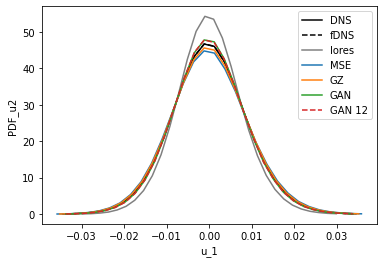

In [30]:
var = 'PDF_u2'
hires[var].plot(label='DNS', ls='-', color='k')
target[var].plot(label='fDNS', ls='--', color='k')
lores[var].plot(label='lores', color='gray')
mse[var].plot(label='MSE')
gz[var].plot(label='GZ', yscale='linear')
gan[var].plot(label='GAN', yscale='linear', xscale='linear')
gan12[var].plot(label='GAN 12', ls='--')
plt.legend()

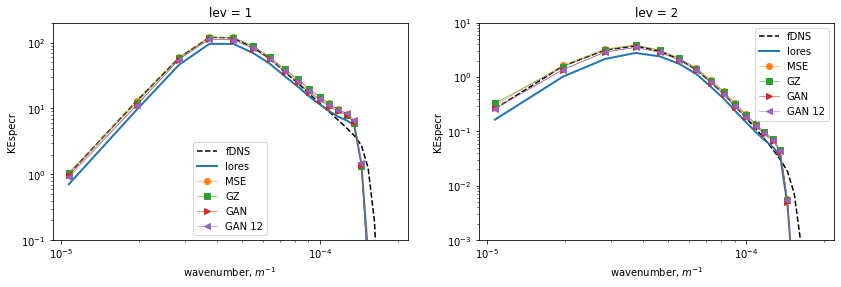

In [31]:
plt.figure(figsize=(14,4))
for lev in [0,1]:
    plt.subplot(1,2,lev+1)
    target.KEspecr.isel(lev=lev).plot(ls='--', color='k', label='fDNS')
    lores.KEspecr.isel(lev=lev).plot(lw=2, label='lores')
    mse.KEspecr.isel(lev=lev).plot(lw=0.5,marker='o', label='MSE')
    gz.KEspecr.isel(lev=lev).plot(lw=0.5,marker='s', label='GZ')
    gan.KEspecr.isel(lev=lev).plot(lw=0.5, label='GAN', marker='>', yscale='log', xscale='log')
    gan12.KEspecr.isel(lev=lev).plot(lw=0.5, label='GAN 12', marker='<', yscale='log', xscale='log')
    if lev==0:
        plt.ylim([1e-1, 2e+2])
    else:
        plt.ylim([1e-3, 1e+1])
    plt.legend()

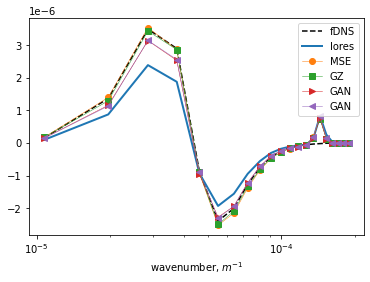

In [32]:
target.KEfluxr.plot(ls='--', color='k', label='fDNS')
lores.KEfluxr.plot(lw=2, label='lores')
(mse.KEfluxr+mse.paramspec_KEfluxr).plot(lw=0.5,marker='o', label='MSE')
(gz.KEfluxr+gz.paramspec_KEfluxr).plot(lw=0.5,marker='s', label='GZ')
(gan.KEfluxr+gan.paramspec_KEfluxr).plot(lw=0.5, label='GAN', marker='>', xscale='log')
(gan12.KEfluxr+gan12.paramspec_KEfluxr).plot(lw=0.5, label='GAN', marker='<', xscale='log')
plt.legend()

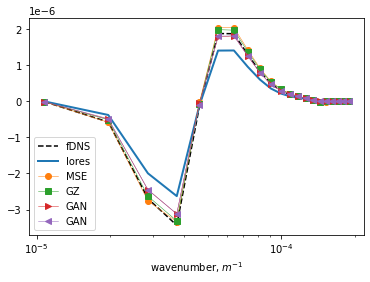

In [33]:
target.APEfluxr.plot(ls='--', color='k', label='fDNS')
lores.APEfluxr.plot(lw=2, label='lores')
(mse.APEfluxr+mse.paramspec_APEfluxr).plot(lw=0.5,marker='o', label='MSE')
(gz.APEfluxr+gz.paramspec_APEfluxr).plot(lw=0.5,marker='s', label='GZ')
(gan.APEfluxr+gan.paramspec_APEfluxr).plot(lw=0.5, label='GAN', marker='>', xscale='log')
(gan12.APEfluxr+gan12.paramspec_APEfluxr).plot(lw=0.5, label='GAN', marker='<', xscale='log')
plt.legend()

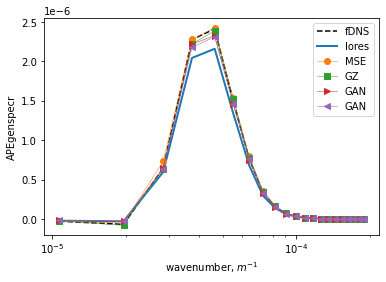

In [34]:
target.APEgenspecr.plot(ls='--', color='k', label='fDNS')
lores.APEgenspecr.plot(lw=2, label='lores')
mse.APEgenspecr.plot(lw=0.5,marker='o', label='MSE')
gz.APEgenspecr.plot(lw=0.5,marker='s', label='GZ')
gan.APEgenspecr.plot(lw=0.5, label='GAN', marker='>', xscale='log')
gan12.APEgenspecr.plot(lw=0.5, label='GAN', marker='<', xscale='log')
plt.legend()

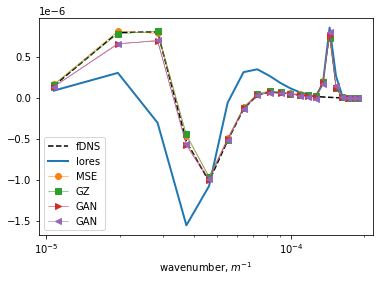

In [35]:
(target.KEfluxr+target.APEfluxr).plot(ls='--', color='k', label='fDNS')
(lores.KEfluxr+target.APEfluxr).plot(lw=2, label='lores')
(mse.KEfluxr+mse.paramspec_KEfluxr+mse.APEfluxr+mse.paramspec_APEfluxr).plot(lw=0.5,marker='o', label='MSE')
(gz.KEfluxr+gz.paramspec_KEfluxr+gz.APEfluxr+gz.paramspec_APEfluxr).plot(lw=0.5,marker='s', label='GZ')
(gan.KEfluxr+gan.paramspec_KEfluxr+gan.APEfluxr+gan.paramspec_APEfluxr).plot(lw=0.5, label='GAN', marker='>', xscale='log')
(gan12.KEfluxr+gan.paramspec_KEfluxr+gan12.APEfluxr+gan.paramspec_APEfluxr).plot(lw=0.5, label='GAN', marker='<', xscale='log')
plt.legend()

# New energy decomposition

In [37]:
def read_ds(path):
    ds = pse.Dataset(path)
    w = ds.relative_vorticity.compute()
    PV_advection = ds.advect(ds.u, ds.v, ds.q).compute()
    RV_advection = ds.advect(ds.u, ds.v, w).compute()
    PV_advection_to_RV = ds.PV_to_relative_vorticity(PV_advection).compute()
    E_flux = op.ave_lev(spectrum(type='cospectrum',averaging=True)(ds.psi, PV_advection),delta=0.25)
    KE_flux = op.ave_lev(spectrum(type='cospectrum',averaging=True)(ds.psi, RV_advection),delta=0.25)
    APE_flux = E_flux - KE_flux
    KE_contribution = op.ave_lev(spectrum(type='cospectrum',averaging=True)(ds.psi, PV_advection_to_RV),delta=0.25)
    APE_contribution = E_flux - KE_contribution
    return dict(E_flux=E_flux, KE_flux=KE_flux, APE_flux=APE_flux, KE_contribution=KE_contribution, APE_contribution=APE_contribution)

In [38]:
hires = read_ds('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/0.nc')

In [39]:
lores = read_ds('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc')

(1e-05, 0.0002)

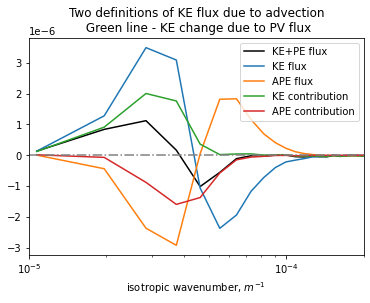

In [40]:
hires['E_flux'].plot(label='KE+PE flux', color='k')
hires['KE_flux'].plot(label='KE flux')
hires['APE_flux'].plot(label='APE flux')
hires['KE_contribution'].plot(label='KE contribution')
hires['APE_contribution'].plot(label='APE contribution', xscale='log')

plt.legend()
plt.title('Two definitions of KE flux due to advection\n Green line - KE change due to PV flux')
plt.axhline(y=0, ls='-.', color='gray')
plt.xlim([1e-5, 2e-4])

(1e-05, 0.0002)

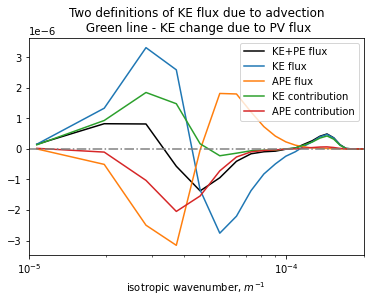

In [41]:
lores['E_flux'].plot(label='KE+PE flux', color='k')
lores['KE_flux'].plot(label='KE flux')
lores['APE_flux'].plot(label='APE flux')
lores['KE_contribution'].plot(label='KE contribution')
lores['APE_contribution'].plot(label='APE contribution', xscale='log')

plt.legend()
plt.title('Two definitions of KE flux due to advection\n Green line - KE change due to PV flux')
plt.axhline(y=0, ls='-.', color='gray')
plt.xlim([1e-5, 2e-4])

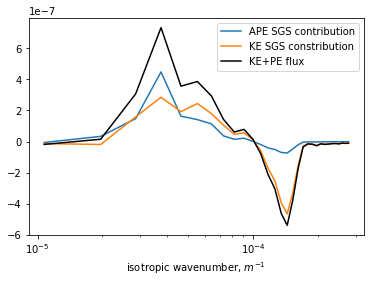

In [53]:
(hires['APE_contribution'] - lores['APE_contribution']).plot(xscale='log', label='APE SGS contribution')
(hires['KE_contribution'] - lores['KE_contribution']).plot(xscale='log', label='KE SGS constribution')
(hires['E_flux'] - lores['E_flux']).plot(label='KE+PE flux', color='k')
plt.legend()

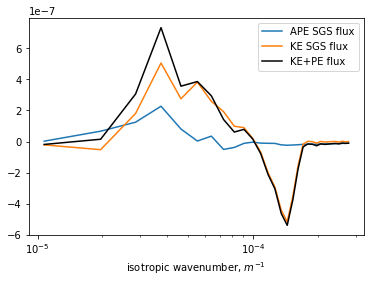

In [55]:
(hires['APE_flux'] - lores['APE_flux']).plot(xscale='log', label='APE SGS flux')
(hires['KE_flux'] - lores['KE_flux']).plot(xscale='log', label='KE SGS flux')
(hires['E_flux'] - lores['E_flux']).plot(label='KE+PE flux', color='k')
plt.legend()

# Ensemble forecasing metrics

In [2]:
operator = 'Operator1'
res = 48
dns = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/AR1-0/*.nc', combine='nested', concat_dim='run')
lores = xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/Reference/eddy-forecast/AR1-0/*.nc', combine='nested', concat_dim='run')

In [17]:
for operator, op_name in zip([op.Operator1, op.Operator2], ['Operator1', 'Operator2']):
    for res in [48, 64, 96]:
        fdns = xr.Dataset()
        for var in ['q', 'u', 'v', 'psi']:
            %time fdns[var] = operator(dns[var], res)
        fdns.to_netcdf(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{op_name}-{str(res)}.nc')

CPU times: user 43.6 s, sys: 24.2 s, total: 1min 7s
Wall time: 1min 7s
CPU times: user 43 s, sys: 22.5 s, total: 1min 5s
Wall time: 1min 7s
CPU times: user 43.1 s, sys: 21.3 s, total: 1min 4s
Wall time: 1min 7s
CPU times: user 43.4 s, sys: 23.4 s, total: 1min 6s
Wall time: 1min 9s
CPU times: user 44.5 s, sys: 21.4 s, total: 1min 5s
Wall time: 1min 5s
CPU times: user 44.7 s, sys: 23.4 s, total: 1min 8s
Wall time: 1min 8s
CPU times: user 44.4 s, sys: 21.8 s, total: 1min 6s
Wall time: 1min 6s
CPU times: user 44.1 s, sys: 20 s, total: 1min 4s
Wall time: 1min 4s
CPU times: user 51.3 s, sys: 24.8 s, total: 1min 16s
Wall time: 1min 16s
CPU times: user 50.4 s, sys: 20.7 s, total: 1min 11s
Wall time: 1min 11s
CPU times: user 51.1 s, sys: 25.2 s, total: 1min 16s
Wall time: 1min 16s
CPU times: user 49.7 s, sys: 21.8 s, total: 1min 11s
Wall time: 1min 11s
CPU times: user 42.8 s, sys: 19.8 s, total: 1min 2s
Wall time: 1min 2s
CPU times: user 43.5 s, sys: 23.6 s, total: 1min 7s
Wall time: 1min 7s
CP

# Precompute spread and shape

In [454]:
gan = ensemble_dataset_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/CGANRegression/eddy-forecast/AR1-48/*.nc',
                     f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{operator}-{str(res)}.nc')
gz = ensemble_dataset_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/MeanVarModel/eddy-forecast/AR1-48/*.nc',
                     f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{operator}-{str(res)}.nc')

(1e-06, 200.0)

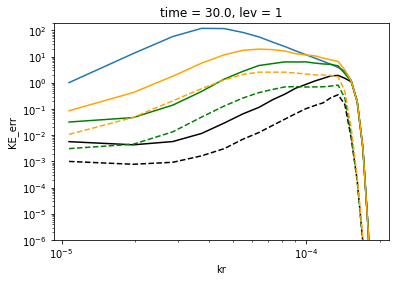

In [455]:
target = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-64.nc')
sp = spectrum(averaging=True, truncate=True)
(sp(target.u) + sp(target.v)).isel(lev=0).plot(xscale='log', yscale='log')
gan.KE_res.isel(time=5,lev=0).plot(ls = '--', color='k')
gan.KE_err.isel(time=5,lev=0).plot(color='k')
gan.KE_res.isel(time=15,lev=0).plot(ls = '--', color='g')
gan.KE_err.isel(time=15,lev=0).plot(color='g')
gan.KE_res.isel(time=30,lev=0).plot(ls = '--', color='orange')
gan.KE_err.isel(time=30,lev=0).plot(color='orange')
plt.ylim([1e-6, 2e+2])

(1e-06, 200.0)

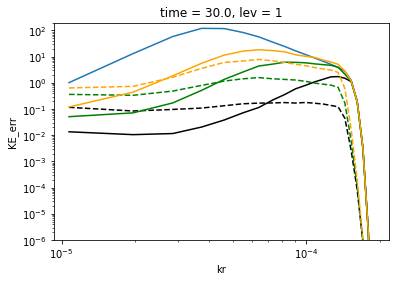

In [456]:
(sp(target.u) + sp(target.v)).isel(lev=0).plot(xscale='log', yscale='log')
gz.KE_res.isel(time=5,lev=0).plot(ls = '--', color='k')
gz.KE_err.isel(time=5,lev=0).plot(color='k')
gz.KE_res.isel(time=15,lev=0).plot(ls = '--', color='g')
gz.KE_err.isel(time=15,lev=0).plot(color='g')
gz.KE_res.isel(time=30,lev=0).plot(ls = '--', color='orange')
gz.KE_err.isel(time=30,lev=0).plot(color='orange')
plt.ylim([1e-6, 2e+2])

In [33]:
for operator in ['Operator1', 'Operator2']:
    for res in [48, 64, 96]:
        for decor in [0, 12, 24, 36, 48]:
            for model in ['CGANRegression-recompute', 'CGANRegression-None-recompute', 'CGANRegression-Unet']:
                m = ensemble_dataset_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/{model}/eddy-forecast/AR1-{str(decor)}/*.nc',
                                     f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{operator}-{str(res)}.nc')
                print(operator, res, decor)

Operator1 48 0
Operator1 48 0
Operator1 48 0
Operator1 48 12
Operator1 48 12
Operator1 48 12
Operator1 48 24
Operator1 48 24
Operator1 48 24
Operator1 48 36
Operator1 48 36
Operator1 48 36
Operator1 48 48
Operator1 48 48
Operator1 48 48
Operator1 64 0
Operator1 64 0
Operator1 64 0
Operator1 64 12
Operator1 64 12
Operator1 64 12
Operator1 64 24
Operator1 64 24
Operator1 64 24
Operator1 64 36
Operator1 64 36
Operator1 64 36
Operator1 64 48
Operator1 64 48
Operator1 64 48
Operator1 96 0
Operator1 96 0
Operator1 96 0
Operator1 96 12
Operator1 96 12
Operator1 96 12
Operator1 96 24
Operator1 96 24
Operator1 96 24
Operator1 96 36
Operator1 96 36
Operator1 96 36
Operator1 96 48
Operator1 96 48
Operator1 96 48
Operator2 48 0
Operator2 48 0
Operator2 48 0
Operator2 48 12
Operator2 48 12
Operator2 48 12
Operator2 48 24
Operator2 48 24
Operator2 48 24
Operator2 48 36
Operator2 48 36
Operator2 48 36
Operator2 48 48
Operator2 48 48
Operator2 48 48
Operator2 64 0
Operator2 64 0
Operator2 64 0
Operato

In [453]:
operator = 'Operator1'
res = 64
fdns = xr.open_dataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{operator}-{str(res)}.nc', decode_times=False)
def coords(ds):
    ds['x'] = fdns['x']
    ds['y'] = fdns['y']
    return ds
lores = coords(xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/Reference/eddy-forecast/AR1-0/*.nc', combine='nested', concat_dim='run', decode_times=False))
mse = coords(xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/OLSModel/eddy-forecast/AR1-0/*.nc', combine='nested', concat_dim='run', decode_times=False))
gz = coords(xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/MeanVarModel/eddy-forecast/AR1-48/*.nc', combine='nested', concat_dim='run', decode_times=False))
gan = coords(xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/CGANRegression/eddy-forecast/AR1-48/*.nc', combine='nested', concat_dim='run', decode_times=False))

In [4]:
def plot_error(model, target, label, var='q', tmax=None):
    model = model.isel(time=slice(0,tmax))
    target = target.isel(time=slice(0,tmax))
    q_err = (model[var+'_mean'].astype('float64') - target[var].astype('float64'))
    q_spread = (model[var].astype('float64') - model[var+'_mean'].astype('float64'))
    normalize = (target[var].astype('float64')**2).mean(dim=('run', 'x', 'y')).isel(time=0)
    
    err = (q_err**2).mean(dim=('run', 'x', 'y')) / normalize
    spread = (q_spread**2).mean(dim=('run', 'x', 'y')) / normalize
    q_sq = (model[var].astype('float64')**2).mean(dim=('run', 'x', 'y')) / normalize
    q_mean_sq = (model[var+'_mean'].astype('float64')**2).mean(dim=('run', 'x', 'y')) / normalize
    
    plt.subplot(1,3,1)
    line, = err.isel(lev=0).plot(label=label, yscale='linear')
    spread.isel(lev=0).plot(ls='--', color=line._color)
    plt.subplot(1,3,2)
    err.isel(lev=1).plot(label=label, yscale='linear')
    spread.isel(lev=1).plot(ls='--', color=line._color)
    plt.subplot(1,3,3)
    q_sq.isel(lev=1).plot(label=label, yscale='linear')
    q_mean_sq.isel(lev=1).plot(ls='--', color=line._color)

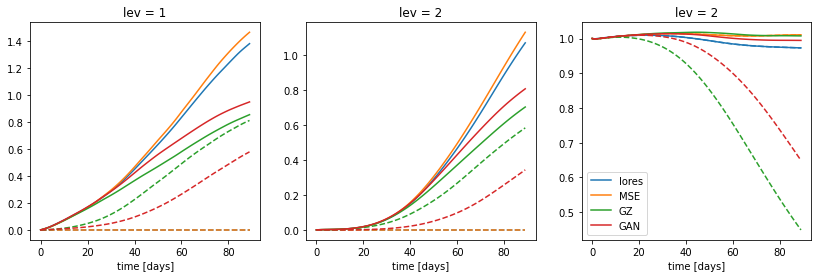

In [5]:
var = 'q'
tmax=90
plt.figure(figsize=(14,4))
plot_error(lores, fdns, 'lores', var, tmax)
plot_error(mse, fdns, 'MSE', var, tmax)
plot_error(gz, fdns, 'GZ', var, tmax)
plot_error(gan, fdns, 'GAN', var, tmax)
plt.legend()

In [4]:
sp = spectrum(averaging=True, truncate=True)

# spectrum of solution

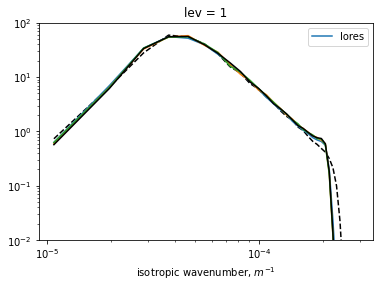

In [22]:
var = 'u'
lev=0
sp(fdns[var].isel(time=0)).isel(lev=lev).plot(color='k', ls='--')
sp(lores[var].isel(time=-1)).isel(lev=lev).plot(label='lores')
sp(mse[var].isel(time=-1)).isel(lev=lev).plot()
sp(gz[var].isel(time=-1)).isel(lev=lev).plot()
sp(gan[var].isel(time=-1)).isel(lev=lev).plot(color='k')
plt.yscale('log')
plt.xscale('log')
if var =='q':
    plt.ylim([1e-8, 1e-5])
elif var=='u' or var=='v':
    plt.ylim([1e-2, 1e+2])
elif var=='psi':
    plt.ylim([1e+7, 1e+12])
plt.legend()

# Spectrum of error and spread

In [2]:
def error(model, target, var, normalize=True):
    er = target[var] - model[var+'_mean']
    if normalize:
        return er / er.std(dim=('x', 'y', 'run'))
    else:
        return er
def spread(model, var, normalize=True):
    er = model[var] - model[var+'_mean']
    if normalize:
        return er / er.std(dim=('x', 'y', 'run'))
    else:
        return er

/ext3/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/ext3/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


([<matplotlib.axis.XTick at 0x15440941c3d0>,
 [Text(0, 0, ''), Text(0, 0, '')])

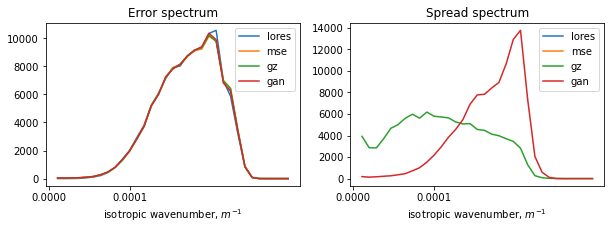

In [25]:
var = 'u'
lev=0
time=5
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
for model, name in zip([lores, mse, gz, gan], ['lores', 'mse', 'gz', 'gan']):
    sp(error(model,fdns,var).isel(time=time)).isel(lev=lev).plot(label=name)
plt.legend()
plt.title('Error spectrum')
plt.xticks([0, 1e-4])
plt.subplot(1,2,2)
for model, name in zip([lores, mse, gz, gan], ['lores', 'mse', 'gz', 'gan']):
    sp(spread(model,var).isel(time=time)).isel(lev=lev).plot(label=name)
plt.legend()
plt.title('Spread spectrum')
plt.xticks([0, 1e-4])

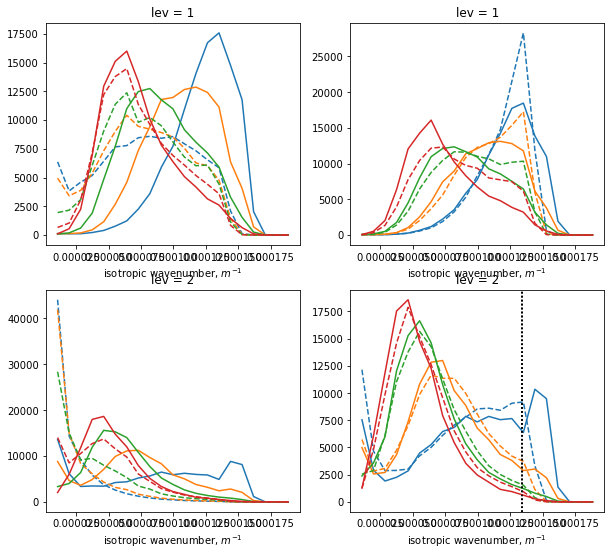

In [18]:
var = 'v'
normalize=True
plt.figure(figsize=(10,9))
for time in [5, 10, 20, 40]:
    
    plt.subplot(2,2,1)
    err = sp(error(gz,fdns,var,normalize).isel(time=time))
    spr = sp(spread(gz,var,normalize).isel(time=time))
    line, = err.isel(lev=0).plot()
    spr.isel(lev=0).plot(ls='--', color=line._color)
    plt.subplot(2,2,3)
    err.isel(lev=1).plot(color=line._color)
    spr.isel(lev=1).plot(ls='--', color=line._color)
    
    plt.subplot(2,2,2)
    err = sp(error(gan,fdns,var,normalize).isel(time=time))
    spr = sp(spread(gan,var,normalize).isel(time=time))
    line, = err.isel(lev=0).plot()
    spr.isel(lev=0).plot(ls='--', color=line._color)
    plt.subplot(2,2,4)
    err.isel(lev=1).plot(color=line._color)
    spr.isel(lev=1).plot(ls='--', color=line._color)
    
    dx = gz.x[2] - gz.x[1]
    kmax = np.pi/dx * 2/3
    plt.axvline(x=kmax, color='k', ls=':')

# Check updated models

In [4]:
import time
base_folder = '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models'
for res in [32, 48, 64, 96]:
    for operator in ['Operator1', 'Operator2']:
        model = 'CGANRegression-None-recompute'
        path = base_folder + '/' + operator + '-' + str(res) + '/' + model + '/training.txt'
        os.system(f'cat {path}')
        os.system(f'ls -l {path}')
        os.system(f'echo {operator}, {res}, {model}')
        time.sleep(0.5)
        input()

Namespace(model='CGANRegression', model_args="{'nx': 32, 'regression': 'None'}", fit_args="{'num_epochs': 600}", train_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-32/*.nc', transfer_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/Operator1-32/*.nc')
Training starts on device NVIDIA A100-SXM4-80GB, number of samples 21500
[1/600] [7.18/4301.43] D_loss: -6.01 G_loss: 2.36 L2_mean: [1.012,1.013] L2_total: [0.338,0.342] L2_res: [0.343,0.340]
[2/600] [7.03/4249.42] D_loss: -2.45 G_loss: 5.17 L2_mean: [1.008,1.008] L2_total: [0.650,0.641] L2_res: [0.568,0.560]
[3/600] [6.97/4215.91] D_loss: -1.80 G_loss: 4.12 L2_mean: [0.997,0.999] L2_total: [0.180,0.172] L2_res: [0.202,0.207]
[4/600] [7.16/4223.93] D_loss: -1.64 G_loss: 4.34 L2_mean: [0.993,0.993] L2_total: [0.247,0.261] L2_res: [0.218,0.233]
[5/600] [6.96/4201.98] D_loss: -1.58 G_loss: 5.22 L2_mean: [0.982,0.981] L2_total: [0.234,0.234] L2_res: [0.221,0.218]
[6/600] [6.94/4182.55] D_loss


Namespace(model='CGANRegression', model_args="{'nx': 32, 'regression': 'None'}", fit_args="{'num_epochs': 600}", train_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator2-32/*.nc', transfer_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/Operator2-32/*.nc')
Training starts on device NVIDIA A100-SXM4-80GB, number of samples 21500
[1/600] [7.23/4328.80] D_loss: -5.47 G_loss: 1.42 L2_mean: [0.996,0.996] L2_total: [0.304,0.311] L2_res: [0.356,0.366]
[2/600] [7.13/4293.10] D_loss: -2.52 G_loss: 4.81 L2_mean: [0.971,0.970] L2_total: [0.401,0.419] L2_res: [0.395,0.410]
[3/600] [7.12/4274.89] D_loss: -1.97 G_loss: 6.28 L2_mean: [0.953,0.953] L2_total: [0.184,0.186] L2_res: [0.243,0.251]
[4/600] [7.00/4243.10] D_loss: -1.77 G_loss: 5.40 L2_mean: [0.943,0.942] L2_total: [0.187,0.192] L2_res: [0.267,0.273]
[5/600] [7.01/4223.04] D_loss: -2.06 G_loss: 4.57 L2_mean: [0.941,0.942] L2_total: [0.130,0.135] L2_res: [0.231,0.233]
[6/600] [7.01/4207.28] D_los


Namespace(model='CGANRegression', model_args="{'nx': 48, 'regression': 'None'}", fit_args="{'num_epochs': 600}", train_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-48/*.nc', transfer_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/Operator1-48/*.nc')
Training starts on device NVIDIA A100-SXM4-80GB, number of samples 21500
[1/600] [10.74/6431.39] D_loss: -10.07 G_loss: 1.55 L2_mean: [1.023,1.023] L2_total: [0.493,0.494] L2_res: [0.432,0.434]
[2/600] [10.74/6421.95] D_loss: -3.67 G_loss: 5.82 L2_mean: [1.014,1.014] L2_total: [0.401,0.397] L2_res: [0.342,0.333]
[3/600] [10.72/6408.16] D_loss: -3.64 G_loss: 5.30 L2_mean: [0.995,0.994] L2_total: [0.225,0.227] L2_res: [0.262,0.259]
[4/600] [10.79/6405.48] D_loss: -2.50 G_loss: 6.17 L2_mean: [0.991,0.991] L2_total: [0.282,0.276] L2_res: [0.240,0.235]
[5/600] [10.51/6366.08] D_loss: -2.63 G_loss: 5.98 L2_mean: [0.981,0.981] L2_total: [0.199,0.194] L2_res: [0.199,0.184]
[6/600] [10.58/6343.59


Namespace(model='CGANRegression', model_args="{'nx': 48, 'regression': 'None'}", fit_args="{'num_epochs': 600}", train_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator2-48/*.nc', transfer_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/Operator2-48/*.nc')
Training starts on device Quadro RTX 8000, number of samples 21500
[1/600] [35.97/21543.74] D_loss: -11.14 G_loss: 2.90 L2_mean: [0.992,0.991] L2_total: [0.547,0.561] L2_res: [0.407,0.406]
[2/600] [35.78/21452.31] D_loss: -4.13 G_loss: 8.26 L2_mean: [0.962,0.961] L2_total: [0.426,0.429] L2_res: [0.457,0.461]
[3/600] [35.81/21403.27] D_loss: -3.37 G_loss: 8.81 L2_mean: [0.945,0.945] L2_total: [0.269,0.267] L2_res: [0.231,0.237]
[4/600] [35.74/21350.79] D_loss: -3.49 G_loss: 7.97 L2_mean: [0.939,0.939] L2_total: [0.301,0.308] L2_res: [0.284,0.291]
[5/600] [36.07/21344.75] D_loss: -3.63 G_loss: 5.99 L2_mean: [0.933,0.934] L2_total: [0.175,0.183] L2_res: [0.240,0.241]
[6/600] [36.06/21327.59


Namespace(model='CGANRegression', model_args="{'nx': 64, 'regression': 'None'}", fit_args="{'num_epochs': 600}", train_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-64/*.nc', transfer_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/Operator1-64/*.nc')
Training starts on device Quadro RTX 8000, number of samples 21500
[1/600] [68.13/40807.35] D_loss: -11.97 G_loss: 6.84 L2_mean: [1.029,1.030] L2_total: [0.446,0.454] L2_res: [0.402,0.408]
[2/600] [68.20/40760.45] D_loss: -5.55 G_loss: 10.02 L2_mean: [1.027,1.028] L2_total: [0.379,0.369] L2_res: [0.318,0.311]
[3/600] [68.07/40673.36] D_loss: -5.16 G_loss: 6.85 L2_mean: [1.008,1.010] L2_total: [0.274,0.276] L2_res: [0.333,0.335]
[4/600] [68.06/40594.52] D_loss: -4.58 G_loss: 8.38 L2_mean: [1.004,1.005] L2_total: [0.216,0.215] L2_res: [0.224,0.223]
[5/600] [67.90/40500.81] D_loss: -4.51 G_loss: 6.71 L2_mean: [0.983,0.982] L2_total: [0.252,0.254] L2_res: [0.281,0.278]
[6/600] [68.04/40429.9


Namespace(model='CGANRegression', model_args="{'nx': 64, 'regression': 'None'}", fit_args="{'num_epochs': 600}", train_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator2-64/*.nc', transfer_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/Operator2-64/*.nc')
Training starts on device NVIDIA A100-SXM4-80GB, number of samples 21500
[1/600] [20.19/12095.52] D_loss: -13.75 G_loss: 9.74 L2_mean: [0.964,0.965] L2_total: [0.416,0.426] L2_res: [0.337,0.341]
[2/600] [20.15/12061.68] D_loss: -4.92 G_loss: 5.77 L2_mean: [0.937,0.937] L2_total: [0.218,0.207] L2_res: [0.258,0.243]
[3/600] [20.02/12011.09] D_loss: -4.44 G_loss: 8.82 L2_mean: [0.926,0.927] L2_total: [0.152,0.152] L2_res: [0.318,0.315]
[4/600] [20.05/11980.42] D_loss: -4.70 G_loss: 7.87 L2_mean: [0.920,0.919] L2_total: [0.218,0.228] L2_res: [0.201,0.192]
[5/600] [20.10/11960.26] D_loss: -5.74 G_loss: 9.29 L2_mean: [0.887,0.887] L2_total: [0.115,0.103] L2_res: [0.229,0.209]
[6/600] [20.14/11


Namespace(model='CGANRegression', model_args="{'nx': 96, 'regression': 'None'}", fit_args="{'num_epochs': 600}", train_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-96/*.nc', transfer_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/Operator1-96/*.nc')
Training starts on device NVIDIA A100-SXM4-80GB, number of samples 21500
[1/600] [83.12/49790.48] D_loss: -24.46 G_loss: 12.42 L2_mean: [1.032,1.032] L2_total: [0.415,0.421] L2_res: [0.409,0.414]
[2/600] [82.88/49636.16] D_loss: -9.21 G_loss: 16.02 L2_mean: [1.029,1.028] L2_total: [0.372,0.373] L2_res: [0.379,0.385]
[3/600] [82.73/49499.21] D_loss: -8.96 G_loss: 14.22 L2_mean: [1.024,1.025] L2_total: [0.310,0.299] L2_res: [0.353,0.341]
[4/600] [82.89/49413.04] D_loss: -11.99 G_loss: 18.07 L2_mean: [1.023,1.023] L2_total: [0.219,0.216] L2_res: [0.235,0.237]
[5/600] [82.79/49315.64] D_loss: -12.71 G_loss: 21.14 L2_mean: [1.024,1.025] L2_total: [0.305,0.297] L2_res: [0.208,0.206]
[6/600] [8


Namespace(model='CGANRegression', model_args="{'nx': 96, 'regression': 'None'}", fit_args="{'num_epochs': 600}", train_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator2-96/*.nc', transfer_path='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/Operator2-96/*.nc')
Training starts on device Quadro RTX 8000, number of samples 21500
[1/600] [117.26/70237.21] D_loss: -24.84 G_loss: 16.01 L2_mean: [0.968,0.969] L2_total: [0.218,0.218] L2_res: [0.247,0.247]
[2/600] [118.49/70487.46] D_loss: -7.71 G_loss: 13.95 L2_mean: [0.930,0.930] L2_total: [0.227,0.236] L2_res: [0.246,0.256]
[3/600] [116.03/70003.76] D_loss: -8.55 G_loss: 14.32 L2_mean: [0.908,0.908] L2_total: [0.260,0.261] L2_res: [0.361,0.364]
[4/600] [115.84/69674.66] D_loss: -9.21 G_loss: 12.95 L2_mean: [0.891,0.892] L2_total: [0.226,0.218] L2_res: [0.201,0.206]
[5/600] [115.90/69437.95] D_loss: -10.24 G_loss: 11.75 L2_mean: [0.864,0.863] L2_total: [0.184,0.184] L2_res: [0.162,0.162]
[6/600] [116

# Why noise introduce energy for spectral filter and does not for Gaussian for GZ Model?

In [26]:
def res(ds):
    return ds.q_forcing_advection - ds.q_forcing_advection_mean
def q_to_psi(q):
    nx = len(q.x)
    m = pyqg.QGModel(nx=nx)
    m.q = q.values.squeeze().astype('float64')
    m._invert()
    return m.to_dataset().p
def dEdt(ds, sgs, tau=48):
    dqdt_mean = sgs.q_forcing_advection_mean
    dqdt_res = res(sgs)
    E_mean = op.ave_lev(spectrum(type='cospectrum')(-ds.psi.squeeze(), dqdt_mean.squeeze()), 0.25)
    E_sgs = op.ave_lev(tau * (60*60) * spectrum(type='cospectrum')(-q_to_psi(dqdt_res).squeeze(), dqdt_res.squeeze()), 0.25)
    return E_mean, E_sgs, E_mean+E_sgs
def plotter(tau=48):
    plt.figure(figsize=(12,4))
    for col, zz in enumerate(zip([ds_offline, ds_online], [sgs_offline, sgs_online], ['offline', 'online'])):
        ds, sgs, name = zz
        noise_var = float(sgs.q_forcing_advection_var.isel(lev=0).mean())
        signal_var = float(sgs.q_forcing_advection.isel(lev=0).var())
        print('Noise to signal var:', noise_var / signal_var)
        print(f'Signal var: {signal_var}, noise var: {noise_var}')
        plt.subplot(1,2,col+1)
        E_mean, E_sgs, E_total = dEdt(ds, sgs, tau)
        E_mean.plot(xscale='log', label='deterministic')
        E_sgs.plot(xscale='log', label='stochastic')
        E_total.plot(xscale='log', label='total')
        plt.legend()
        plt.title(f'Subgrid energy flux({name})')
        dx = ds.x[2] - ds.x[1]
        plt.axvline(x=np.pi/dx, ls='--', color='k')
        plt.text(np.pi/dx, 0, '$\pi/dx$',fontsize=20)
def read_model_and_data(model_name, operator, res=64, sampling='AR1-48'):
    model_folder = f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/{model_name}/model'
    with open(model_folder+'/model_args.json') as file:
        model_args = json.load(file)
    model = eval(model_args.pop('model'))(**model_args, folder=model_folder)
    ds_offline = xr.open_dataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/{operator}-{str(res)}/0.nc').expand_dims('run').isel(time=slice(-1,None))
    ds_online = xr.open_dataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(res)}/{model_name}/eddy-{sampling}/0.nc').expand_dims('run').isel(time=slice(-1,None))
    sgs_offline = model.predict(ds_offline)
    sgs_online = model.predict(ds_online)
    return ds_offline, ds_online, sgs_offline, sgs_online

# GZ Model, Operator1

In [175]:
ds_offline, ds_online, sgs_offline, sgs_online = read_model_and_data('MeanVarModel', 'Operator1')

reading MeanVarModel from /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/MeanVarModel/model


INFO:  Logger initialized
INFO:  Logger initialized


Noise to signal var: 0.164172626384919
Signal var: 6.909588296388659e-23, noise var: 1.1343652578566243e-23
Noise to signal var: 0.17702321419716568
Signal var: 1.093076839154387e-22, noise var: 1.9349997543158787e-23


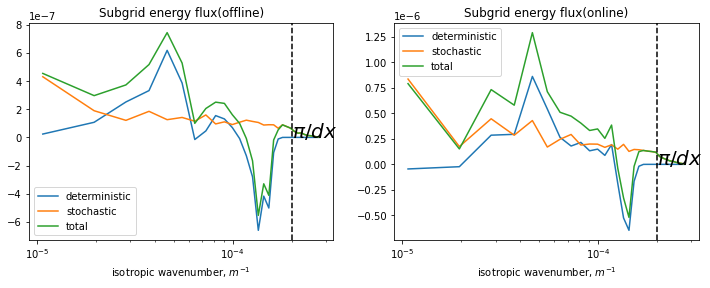

In [176]:
plotter()

# GZ model, Operator2

In [177]:
ds_offline, ds_online, sgs_offline, sgs_online = read_model_and_data('MeanVarModel', 'Operator2')

reading MeanVarModel from /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/MeanVarModel/model


INFO:  Logger initialized
INFO:  Logger initialized


Noise to signal var: 0.13111895216279687
Signal var: 1.818916640171931e-23, noise var: 2.384944439308186e-24
Noise to signal var: 0.2108984961269248
Signal var: 8.24667754807424e-24, noise var: 1.7392118929325326e-24


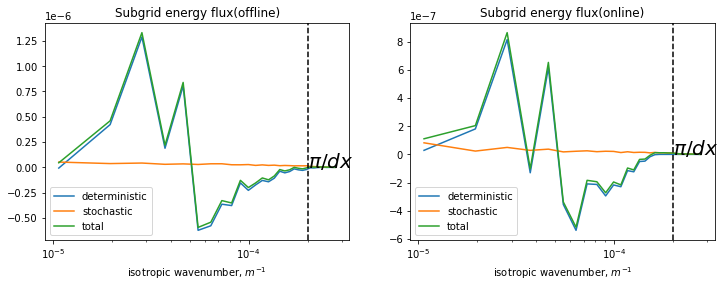

In [178]:
plotter()

# GAN Operator1

In [28]:
ds_offline, ds_online, sgs_offline, sgs_online = read_model_and_data('CGANRegression', 'Operator1', sampling='AR1-48')

reading CGANRegression from /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/model


INFO:  Logger initialized
INFO:  Logger initialized


Noise to signal var: 0.19801337505895994
Signal var: 7.045702970828053e-23, noise var: 1.3951434249166034e-23
Noise to signal var: 0.17563288962688417
Signal var: 1.0827203014402323e-22, noise var: 1.9016129519963908e-23


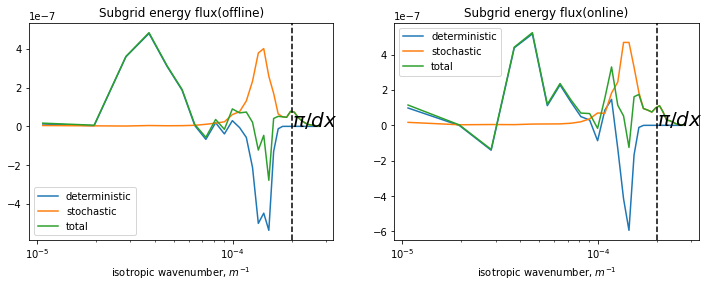

In [29]:
plotter(48)

# GAN Operator2

In [37]:
ds_offline, ds_online, sgs_offline, sgs_online = read_model_and_data('CGANRegression', 'Operator2', sampling='AR1--1')

reading CGANRegression from /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CGANRegression/model


INFO:  Logger initialized
INFO:  Logger initialized


Noise to signal var: 0.21985398034059328
Signal var: 1.799138658230733e-23, noise var: 3.9554779519666094e-24
Noise to signal var: 0.37621071068440215
Signal var: 8.509239847366413e-24, noise var: 3.2012671703617517e-24


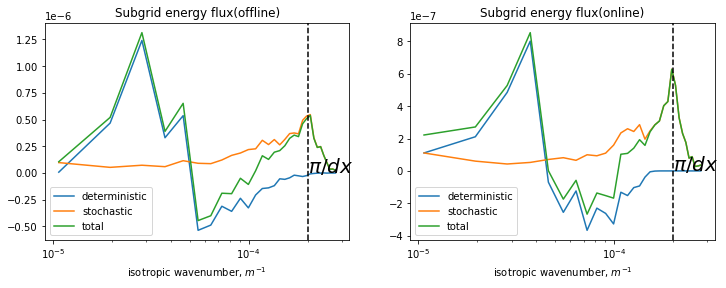

In [38]:
plotter(tau=720)

### Comparison figure

In [32]:
ds_offline, _, sgs_gan, _ = read_model_and_data('CGANRegression', 'Operator1', sampling='AR1-48')
_, _, sgs_gz, _ = read_model_and_data('MeanVarModel', 'Operator1', sampling='AR1-48')

reading CGANRegression from /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/model
reading MeanVarModel from /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/MeanVarModel/model


In [33]:
E_mean, E_sgs_gan, _ = dEdt(ds_offline, sgs_gan, 48)
E_mean, E_sgs_gz, _ = dEdt(ds_offline, sgs_gz, 48)

INFO:  Logger initialized
INFO:  Logger initialized


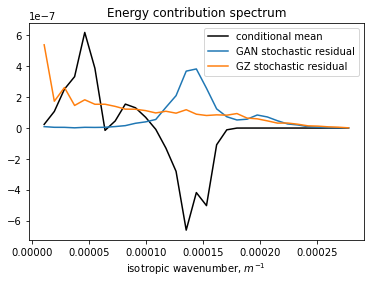

In [40]:
E_mean.plot(color='k', label='conditional mean')
E_sgs_gan.plot(label='GAN stochastic residual')
E_sgs_gz.plot(label='GZ stochastic residual')
plt.legend()
plt.title('Energy contribution spectrum')
plt.savefig('dEdt_stochastic_GAN_GZ.pdf')

# Check ensemble forecast files

In [14]:
import time
import os
base_folder = '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models'
for res in [48, 64, 96]:
    for operator in ['Operator1', 'Operator2']:
        for model in ['CGANRegression-recompute', 'CGANRegression-None-recompute', 'CGANRegression-Unet']:
            for decor in [0, 12, 24, 48]:
                path = base_folder + '/' + operator + '-' + str(res) + '/' + model + f'/eddy-forecast/AR1-{str(decor)}'
                #os.system(f'cat {path}/out-* | grep "Saving to file" | wc -l')
                #os.system(f'ls {path}/*.nc | wc -l')
                #os.system(f'echo {path}')
                nfile = len(glob.glob(path+'/*.nc'))
                if nfile !=15:
                    print(nfile, path)

# Check online simulations

In [15]:
import time
import os
base_folder = '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models'
d = []
for res in [48, 64, 96]:
    print('\n')
    for operator in ['Operator1', 'Operator2']:
        for model in ['OLSModel', 'MeanVarModel', 'CGANRegression', 'CGANRegression-recompute', 'CGANRegression-None-recompute', 'CGANRegression-Unet']:
            for decor in ['eddy-3600-constant-0']:
                path = base_folder + '/' + operator + '-' + str(res) + '/' + model + f'/{decor}'
                nfile = len(glob.glob(f'{path}/*.nc'))
                if nfile != 10:
                    print(nfile, path)
                    #os.system(f'grep CANCEL {path}/*')
                    #d.append(operator+str(res)+str(model)+str(decor))



8 /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-3600-constant-0
7 /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/MeanVarModel/eddy-3600-constant-0




9 /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96/MeanVarModel/eddy-3600-constant-0
0 /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/CGANRegression-recompute/eddy-3600-constant-0
4 /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/CGANRegression-None-recompute/eddy-3600-constant-0
4 /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/CGANRegression-Unet/eddy-3600-constant-0


# All statistics GANs

In [21]:
from pyqg_generative.tools.operators import ave_lev
def plot_all_statistics(operator='Operator1', resolution=48, read_cache=True, sampling='constant-0', xlim=[1e-5, 2e-4], ylim1=[1e-1,2e+2], ylim2=[1e-2,1e+1]):    
    if resolution==64:
        ylim2=[5e-3,1e+1]
    elif resolution==96:
        xlim=[1e-5, 3e-4]
        ylim1=[1e-2, 2e+2]
        ylim2=[1e-4,1e+1]
    
    dns_line = {'color': 'k', 'ls': '-', 'lw': 1, 'label': 'DNS'}
    target_line = {'color': 'k', 'ls': '--', 'lw': 2, 'label': 'fDNS'}
    lores_line = {'color': 'gray', 'ls': '-', 'lw': 2, 'label': 'lores'}
    mse_line = {'color': '#1f77b4', 'ls': '-', 'lw': 0.5, 'marker': 'o', 'markersize': 4, 'fillstyle':'full', 'markeredgewidth':1.5, 'label': 'MSE'}
    gz_line = {'color': '#ff7f0e', 'ls': '-', 'lw': 0.5, 'marker': 's', 'markersize': 4, 'fillstyle': 'full', 'markeredgewidth':1, 'label': 'GZ'}
    gan_line = {'color': '#2ca02c', 'ls': '-', 'lw': 0.5, 'marker': '>', 'markersize': 4, 'fillstyle':'full', 'markeredgewidth':1, 'label': 'GAN'}
    
    gan_2_line = {'color': '#2ca02c', 'ls': '-', 'lw': 0.5, 'marker': '<', 'markersize': 4, 'fillstyle':'full', 'markeredgewidth':1, 'label': 'GAN'}
    gan_full_line = {'color': 'tab:red', 'ls': '-', 'lw': 0.5, 'marker': 'X', 'markersize': 4, 'fillstyle':'full', 'markeredgewidth':1, 'label': 'GAN-full'}
    gan_unet_line = {'color': 'tab:purple', 'ls': '-', 'lw': 0.5, 'marker': 'd', 'markersize': 4, 'fillstyle':'full', 'markeredgewidth':1, 'label': 'GAN-Unet'}
    
    mse_of_line = {'color': '#1f77b4', 'ls': '--', 'label': 'MSE'}
    gz_of_line = {'color': '#ff7f0e', 'ls': '--', 'label': 'GZ'}
    gan_of_line = {'color': '#2ca02c', 'ls': '--', 'label': 'GAN'}
    
    
    plt.rcParams.update({'font.size': 12})
    fig, axs = plt.subplots(2,3, figsize=(14,6))
    plt.subplots_adjust(wspace=0.3, hspace=0.65)
    
    hires = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc', read_cache=read_cache)
    target = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/{operator}-{str(resolution)}.nc', read_cache=read_cache)
    lores = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_{str(resolution)}/[0-9].nc', read_cache=read_cache)
    mse = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(resolution)}/OLSModel/eddy-constant-0/*.nc', read_cache=read_cache)
    gz = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(resolution)}/MeanVarModel/eddy-{sampling}/*.nc', read_cache=read_cache)
    gan = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(resolution)}/CGANRegression/eddy-{sampling}/*.nc', read_cache=read_cache)
    gan_2 = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(resolution)}/CGANRegression-recompute/eddy-{sampling}/*.nc', read_cache=read_cache)
    gan_full = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(resolution)}/CGANRegression-None-recompute/eddy-{sampling}/*.nc', read_cache=read_cache)
    gan_unet = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(resolution)}/CGANRegression-Unet/eddy-{sampling}/*.nc', read_cache=read_cache)
    
    offline = xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/{operator}-{str(resolution)}/*.nc', combine="nested", concat_dim="run").isel(run=slice(275,285))
    offline['paramspec_KEfluxr'] = ave_lev(spectrum(type='cospectrum', averaging=True, truncate=True)(-offline.psi, offline.q_forcing_advection), 0.25)
    offline['paramspec_APEfluxr'] = 0*offline['paramspec_KEfluxr']
    
    if operator == 'Operator1' and resolution == 48:
        models = [mse, gz, gan, gan_2, gan_full]
        lines = [mse_line, gz_line, gan_line, gan_2_line, gan_full_line]
    else:
        models = [mse, gz, gan, gan_2, gan_full, gan_unet]
        lines = [mse_line, gz_line, gan_line, gan_2_line, gan_full_line, gan_unet_line]
    
    ax = axs[0][0]
    for model, line in zip([hires, target, lores, *models], 
        [dns_line, target_line, lores_line, *lines]):
        line2 = line.copy()
        if 'marker' in line:
            line2['lw'] = 0
        model.KEspecr.isel(lev=0).plot(ax=ax, **line2)
    for model, line in zip([hires, target, lores, *models], 
        [dns_line, target_line, lores_line, *lines]):
        line2 = line.copy()
        if 'marker' in line:
            line2['lw'] = 0
        model.KEspecr.isel(lev=1).plot(ax=ax, **line2)
        
    #ax.set_ylim(ylim1)
    ax.set_ylim([min(ylim2), max(ylim1)])
    ax.set_xlim(xlim)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('KE spectrum')
    ax.set_ylabel('Energy spectrum [$m^3/s^2$]', fontsize=11)
    ax.text(1.3e-4, 1.5e-1, 'lower')
    ax.text(1.2e-4, 1.5e+1, 'upper')
    
    ax = axs[1][0]
    for model, line in zip([hires, target, lores, *models], 
        [dns_line, target_line, lores_line, *lines]):
        model.Efluxr.plot(ax=ax, **line)
    ax.set_xscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim([-1.2e-6, 1.2e-6])
    ax.set_title('Energy transfer \n (resolved+subgrid)')
    ax.set_ylabel('Energy change [$m^3/s^3$]', fontsize=11)
    
    ax=axs[1][1]
    for model, line in zip([offline, *models],
        [target_line, *lines]):
        (model.paramspec_APEfluxr + model.paramspec_KEfluxr).plot(ax=ax, **line)
    ax.set_xlim(xlim)
    ax.set_xscale('log')
    ax.set_ylabel('Energy change [$m^3/s^3$]', fontsize=11)
    ax.set_title('Energy transfer \n (subgrid)')
    
    ax = axs[0][1]
    for model, line in zip([hires, target, lores, *models], 
        [dns_line, target_line, lores_line, *lines]):
        model.APEgenspecr.plot(ax=ax, **line)
    ax.set_xscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim([-2e-7, 2.5e-6])
    ax.set_title('Energy source')
    ax.set_ylabel('Energy change [$m^3/s^3$]', fontsize=11)
    
    ax = axs[0][2]
    for model, line in zip([hires, target, lores, *models], 
        [dns_line, target_line, lores_line, *lines]):
        line2 = line.copy()
        if 'marker' in line:
            line2['lw'] = 0
        model.KE_time.plot(ax=ax, markevery=6, **line2)
    ax.set_title('KE per unit mass')
    ax.set_ylabel('Kinetic energy [$10^{-4} m^2/s^2$]', fontsize=11)
    ax.set_ylim([0, 8e-4])
    ax.set_yticks([0, 2e-4, 4e-4, 6e-4, 8e-4])
    ax.set_yticklabels([0,2,4,6,8])
    
    
    ax = axs[1][2]
    for model, line in zip([hires, target, lores, *models], 
        [dns_line, target_line, lores_line, *lines]):
        line2 = line.copy()
        if 'marker' in line:
            line2['lw'] = 0
        model.PDF_Ens1.plot(ax=ax, markevery=2, **line2)
    ax.set_yscale('log')
    ax.set_title('Upper enstrophy PDF')
    ax.set_ylabel('Probability density', fontsize=11)
    ax.set_xlabel('relative enstrophy [$10^{-11}s^{-2}$]')
    ax.set_xticks([0, 2e-11, 4e-11, 6e-11, 8e-11, 10e-11])
    ax.set_xticklabels([0, 2, 4, 6, 8, 10])
    ax.set_ylim([5e+7, 1e+12])
    
    fig.align_ylabels()
    fig.align_xlabels()
    axs[1][2].legend(frameon=False, ncol=2, fontsize=9)

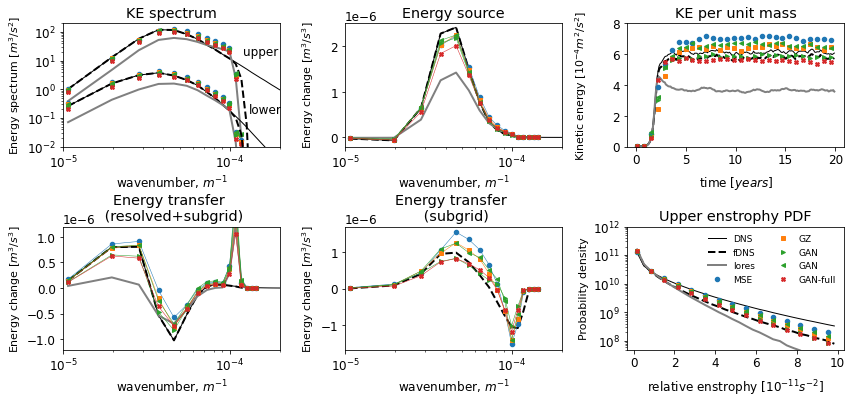

In [18]:
plot_all_statistics(operator='Operator1', resolution=48)
plt.savefig('paper_figures/online_overview/op1_48_GANs.pdf', bbox_inches='tight', pad_inches=0.1)

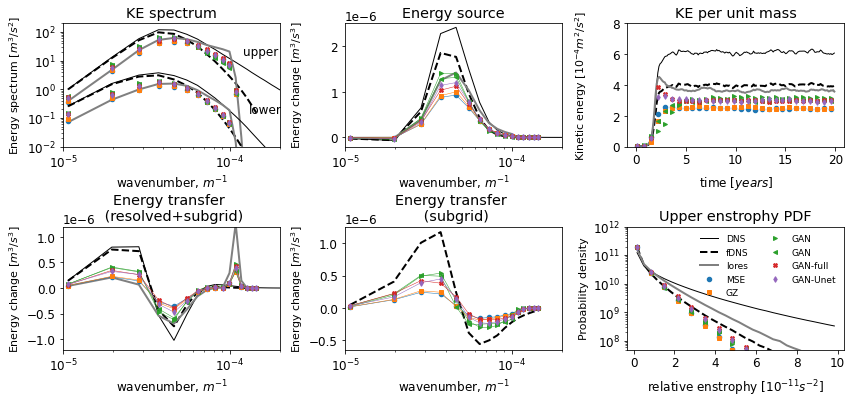

In [22]:
plot_all_statistics(operator='Operator2', resolution=48)
plt.savefig('paper_figures/online_overview/op2_48_GANs.pdf', bbox_inches='tight', pad_inches=0.1)

# Library plotter

['MSE', 'GZ', 'GAN', 'GAN', 'GAN-full', 'GAN Unet']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator2-64.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_64/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/OLSModel/jet-3600-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/MeanVarModel/jet-3600-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CGANRegression/jet-3600-constant-0/[0-9].nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 0
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CGANRegression-recompute/jet-3600-constant-0/[0-9].nc
Warning! Computations are unstable. Nu

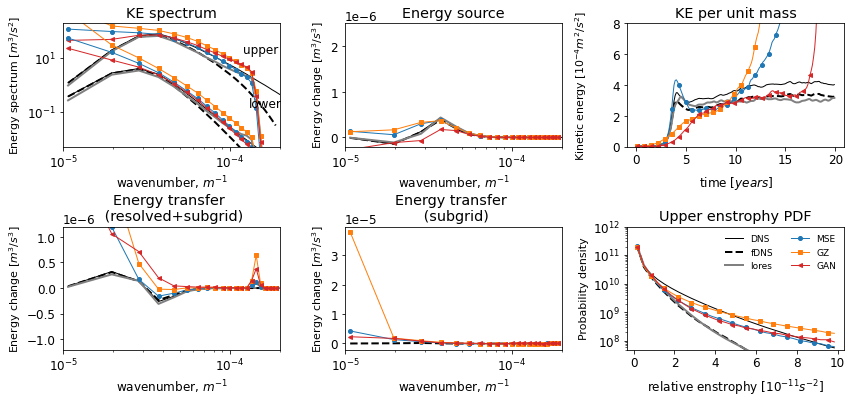

In [3]:
plot_panel_figure(operator='Operator2', resolution=64, configuration='jet', models_folders=['OLSModel', 'MeanVarModel', 'CGANRegression', 'CGANRegression-recompute', 'CGANRegression-None-recompute', 'CGANRegression-Unet'], samplings = '3600-constant-0', labels=['MSE', 'GZ', 'GAN','GAN', 'GAN-full', 'GAN Unet'], markers=['o', 's', '>', '<'])
plt.savefig('plot.pdf')

['OLSModel', 'MeanVarModel']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator2-64.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_64/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CGANRegression-recompute/jet-3600-constant-0/[0-9].nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 4


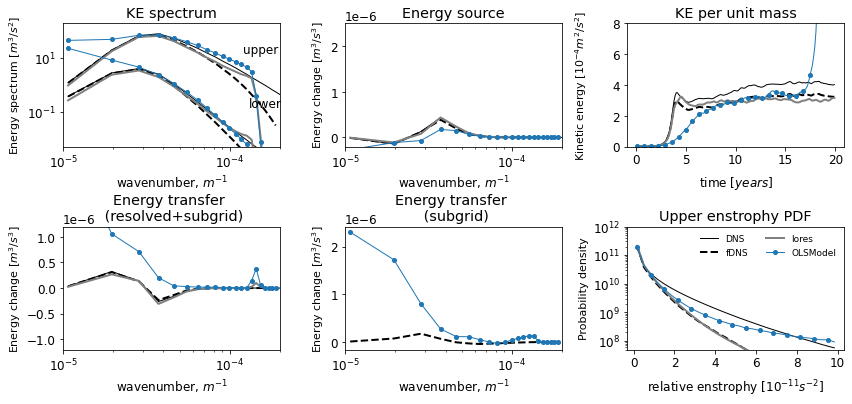

In [6]:
plot_panel_figure(operator='Operator2', resolution=64, configuration='jet', models_folders=['CGANRegression-recompute'], samplings = '3600-constant-0')
plt.savefig('plot.pdf')

# dt sensitivity

2 ['large dt', '$1h$']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator1-96.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_96/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_3600_96/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96/OLSModel/jet-constant-0/[0-9].nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 2
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96/OLSModel/jet-3600-constant-0/[0-9].nc


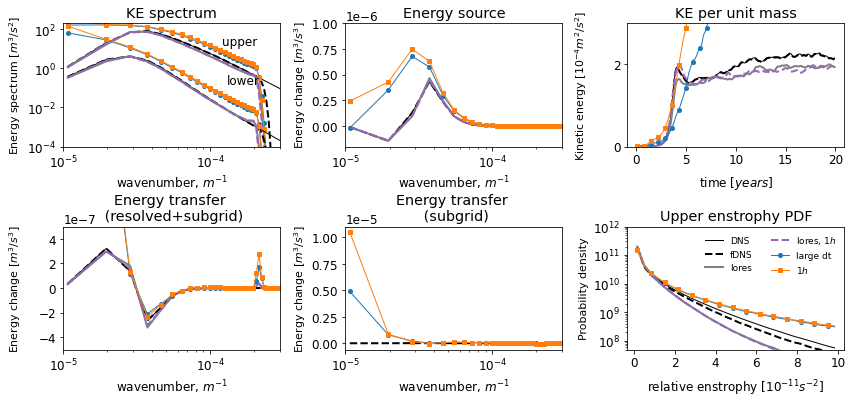

In [116]:
ax = plot_panel_figure(operator='Operator1', resolution=96, configuration='jet', models_folders = ['OLSModel']*2, samplings=['constant-0', '3600-constant-0'], labels=['large dt', '$1h$'], read_cache=True)
ax[0][2].set_ylim([0,3e-4])
ax[0][1].set_ylim([-0.2e-6,1e-6])
ax[1][0].set_ylim([-0.5e-6,0.5e-6])
plt.savefig('plot.pdf')

# OLS vs GAN

2 ['MSE-div', 'GAN-div']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator2-96.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_96/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_3600_96/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/OLSModel-div/jet-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/CGANRegression-div/jet-constant-0/[0-9].nc


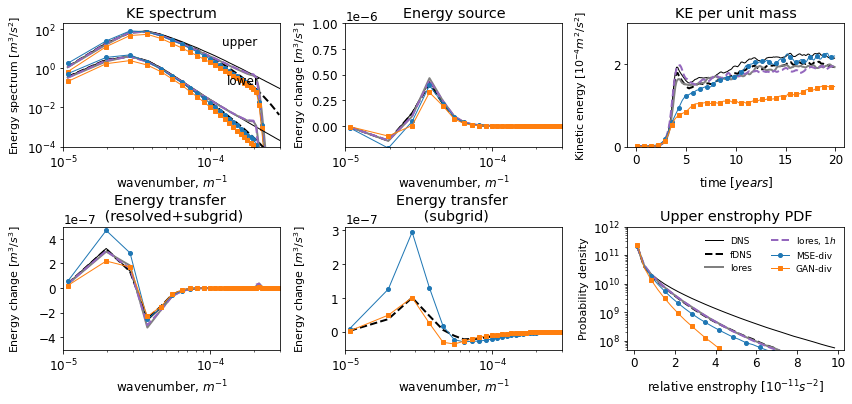

In [96]:
ax = plot_panel_figure(operator='Operator2', resolution=96, configuration='jet', models_folders=['OLSModel-div', 'CGANRegression-div'], samplings = 'constant-0', labels=['MSE-div', 'GAN-div'], markers=['o', 's'])
ax[0][2].set_ylim([0,3e-4])
ax[0][1].set_ylim([-0.2e-6,1e-6])
ax[1][0].set_ylim([-0.5e-6,0.5e-6])
plt.savefig('plot.pdf')

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator1-96.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_96/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96/OLSModel-div/jet-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96/CGANRegression-div/jet-constant-0/[0-9].nc
0 0.012789126718416812
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator1-96.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_96/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/mode

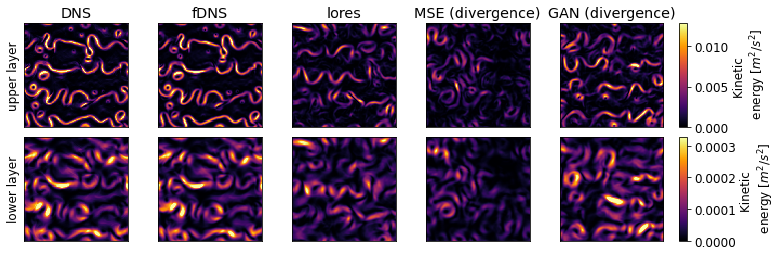

In [120]:
plot_solution(operator='Operator1', resolution=96, configuration='jet', models_folders=['OLSModel-div', 'CGANRegression-div'], labels=['MSE (divergence)', 'GAN (divergence)'])

# DIfference

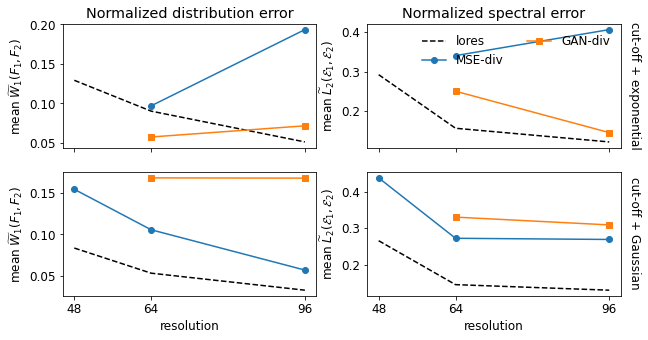

In [218]:
ax = plot_difference(models=['Reference','OLSModel-div', 'CGANRegression-div'], 
                     labels=['lores','MSE-div', 'GAN-div'], configuration='jet', timestep='')

(0.0, 1.0)

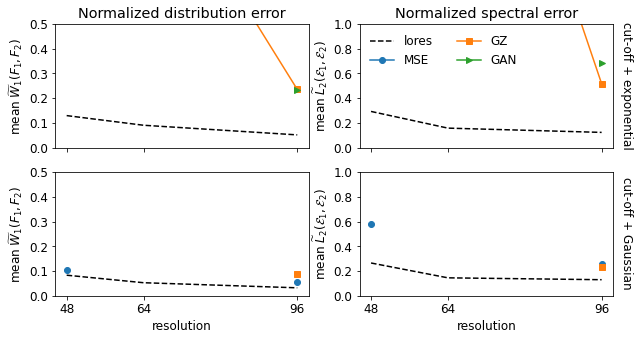

In [232]:
ax = plot_difference(models=['Reference','OLSModel', 'MeanVarModel', 'CGANRegression'], 
                     labels=['lores','MSE', 'GZ', 'GAN'], configuration='jet', timestep='')
ax[0][0].set_ylim([0, 0.5])
ax[0][1].set_ylim([0, 1])
ax[1][0].set_ylim([0, 0.5])
ax[1][1].set_ylim([0, 1])

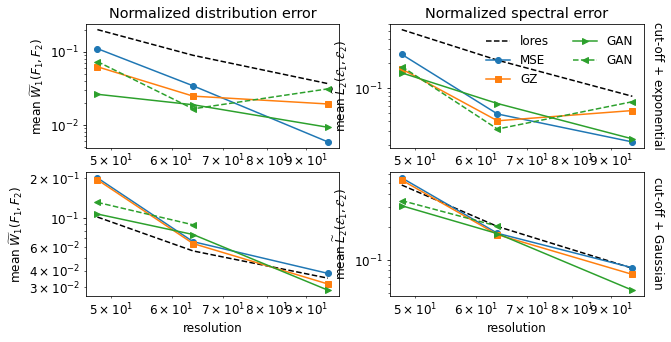

In [207]:
ax = plot_difference(models=['Reference','OLSModel', 'MeanVarModel', 'CGANRegression', 'CGANRegression-recompute'], 
                     labels=['lores','MSE', 'GZ', 'GAN', 'GAN'], configuration='eddy')
for i in range(2):
    for j in range(2):
        ax[i][j].set_yscale('log')
        ax[i][j].set_xscale('log')

# VAE offline

In [138]:
def plot(path, title='', lev=0):
    ds = xr.open_dataset(path)
    ds.PSD_res.isel(lev=lev).plot(label='residual')
    (3*ds.PSD_gen_res.isel(lev=lev)).plot(ls='-.', label='generated \n residual \n ($PSD\\times 3$)')
    plt.legend()
    plt.title(title)

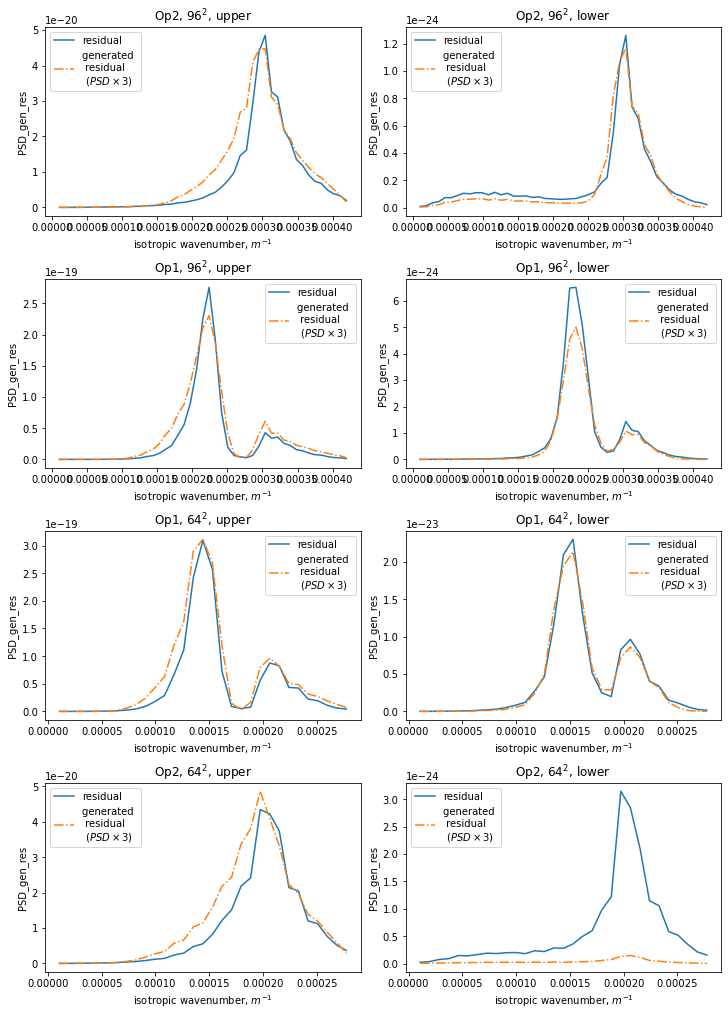

In [144]:
plt.figure(figsize=(10,14), constrained_layout=True)
plt.subplot(4,2,1)
plot('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/CVAERegression-None/offline_test.nc', title='Op2, $96^2$, upper', lev=0)
plt.subplot(4,2,2)
plot('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/CVAERegression-None/offline_test.nc', title='Op2, $96^2$, lower', lev=1)
plt.subplot(4,2,3)
plot('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96/CVAERegression-None/offline_test.nc', title='Op1, $96^2$, upper', lev=0)
plt.subplot(4,2,4)
plot('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96/CVAERegression-None/offline_test.nc', title='Op1, $96^2$, lower', lev=1)
plt.subplot(4,2,5)
plot('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CVAERegression-None/offline_test.nc', title='Op1, $64^2$, upper', lev=0)
plt.subplot(4,2,6)
plot('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CVAERegression-None/offline_test.nc', title='Op1, $64^2$, lower', lev=1)
plt.subplot(4,2,7)
plot('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CVAERegression-None/offline_test.nc', title='Op2, $64^2$, upper', lev=0)
plt.subplot(4,2,8)
plot('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CVAERegression-None/offline_test.nc', title='Op2, $64^2$, lower', lev=1)
plt.savefig('PSD_VAE.pdf', bbox_inches='tight', pad_inches=0.1)

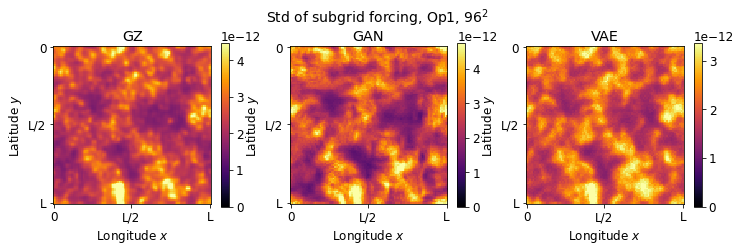

In [123]:
path = '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96'
idx = dict(run=0, time=-1, lev=0)
var = 'q_forcing_advection_std'
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
pse.imshow(xr.open_dataset(f'{path}/MeanVarModel/offline_test.nc').isel(idx)[var])
plt.title('GZ')
plt.subplot(1,3,2)
pse.imshow(xr.open_dataset(f'{path}/CGANRegression/offline_test.nc').isel(idx)[var])
plt.title('GAN')
plt.subplot(1,3,3)
pse.imshow(xr.open_dataset(f'{path}/CVAERegression-None/offline_test.nc').isel(idx)[var])
plt.title('VAE')
plt.suptitle('Std of subgrid forcing, Op1, $96^2$', y=1.05, fontsize=14)
plt.savefig('GZ_GAN_VAE_std.pdf', bbox_inches='tight', pad_inches=0.1)

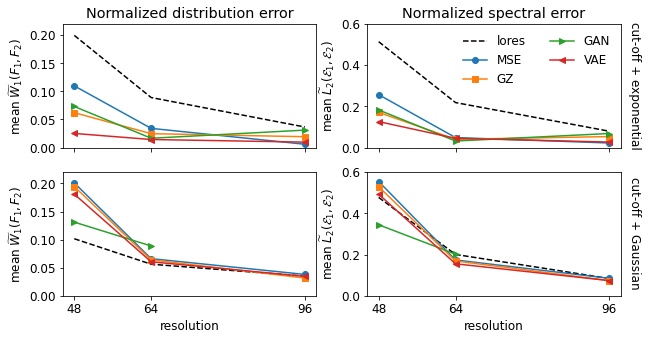

In [166]:
ax = plot_difference(normalize=False, models=['Reference','OLSModel', 'MeanVarModel', 'CGANRegression-recompute', 'CVAERegression-None'], labels=['lores', 'MSE', 'GZ', 'GAN', 'VAE'], sampling='constant-0', configuration='eddy')
plt.savefig('online_errors_VAE.pdf', bbox_inches='tight', pad_inches=0.1)

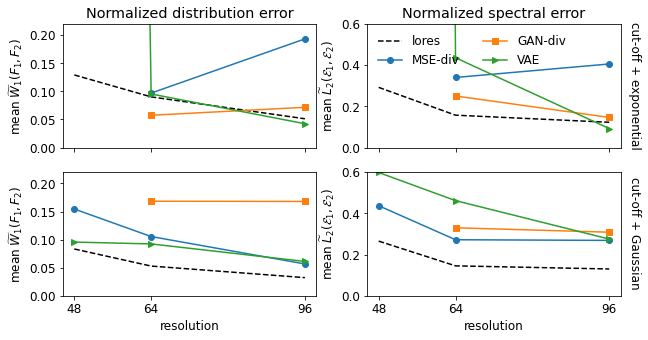

In [167]:
ax = plot_difference(models=['Reference', 'OLSModel-div', 'CGANRegression-div', 'CVAERegression-None'], labels=['lores', 'MSE-div', 'GAN-div', 'VAE'], sampling='constant-0', configuration='jet')
plt.savefig('online_errors_VAE_jet.pdf', bbox_inches='tight', pad_inches=0.1)

4 ['MSE', 'GZ', 'GAN', 'VAE']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_3600_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/MeanVarModel/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression-recompute/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CVAERegression-None/eddy-constant-0/[0-9].nc


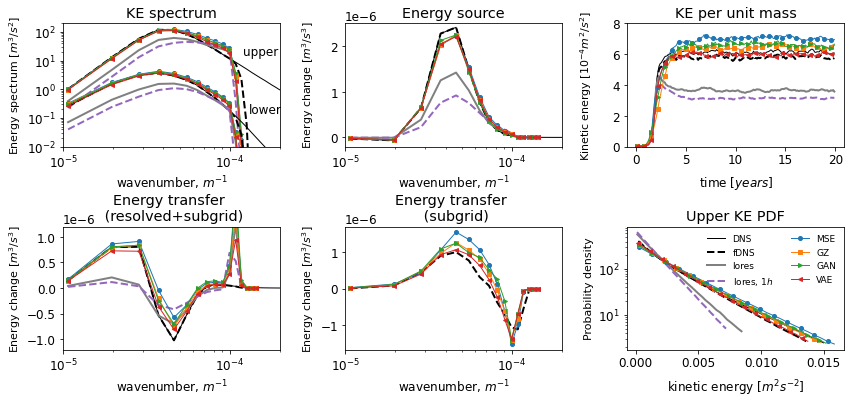

In [177]:
ax = plot_panel_figure(density='PDF_KE1', operator='Operator1', resolution=48, configuration='eddy', models_folders=['OLSModel', 'MeanVarModel', 'CGANRegression-recompute', 'CVAERegression-None'], samplings = 'constant-0', labels=['MSE', 'GZ', 'GAN', 'VAE'], markers=['o', 's', '>', '<']);
plt.savefig('online_overview_VAE.pdf', bbox_inches='tight', pad_inches=0.1)

5 ['MSE', 'GZ', 'GAN', 'GAN', 'VAE']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator2-64.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_64/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_3600_64/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/OLSModel/jet-3600-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/MeanVarModel/jet-3600-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CGANRegression/jet-3600-constant-0/[0-9].nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 0
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CGANRegression-reco

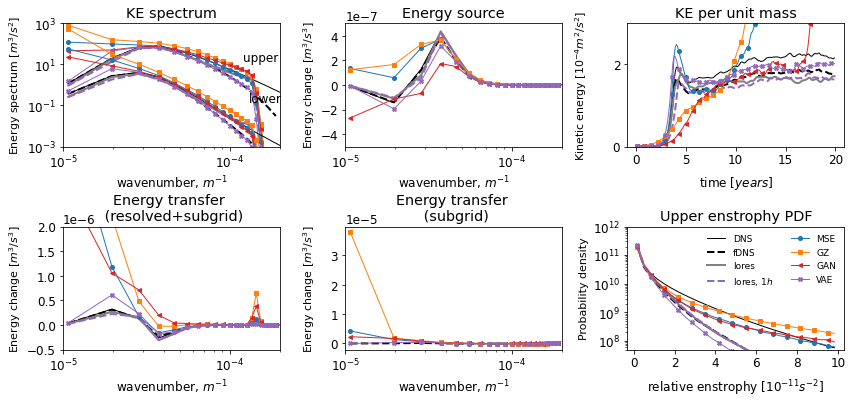

In [182]:
ax = plot_panel_figure(density='PDF_Ens1', operator='Operator2', resolution=64, configuration='jet', models_folders=['OLSModel', 'MeanVarModel', 'CGANRegression', 'CGANRegression-recompute', 'CVAERegression-None'], samplings = '3600-constant-0', labels=['MSE', 'GZ', 'GAN', 'GAN', 'VAE'], markers=['o', 's', '>', '<'], read_cache=True);
ax[0][2].set_ylim([0,3e-4])
ax[0][0].set_ylim([1e-3, 1e+3])
ax[0][1].set_ylim([-0.5e-6, 0.5e-6])
ax[1][0].set_ylim([-0.5e-6, 2e-6])
plt.savefig('online_overview_VAE_jet.pdf', bbox_inches='tight', pad_inches=0.1)

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator1-96.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_96/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96/OLSModel-div/jet-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96/CGANRegression-div/jet-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96/CVAERegression-None/jet-constant-0/[0-9].nc
0 0.012789126718416812
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator1-96.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_ge

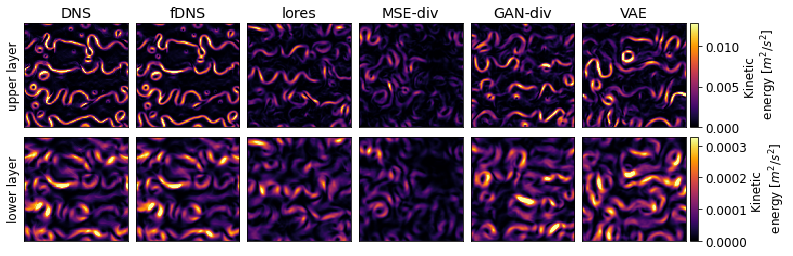

In [184]:
plot_solution(operator='Operator1', resolution=96, configuration='jet', models_folders=['OLSModel-div', 'CGANRegression-div', 'CVAERegression-None'], labels=['MSE-div', 'GAN-div', 'VAE'])
plt.savefig('snapshot_op1_96_VAE.pdf', bbox_inches='tight', pad_inches=0.1)

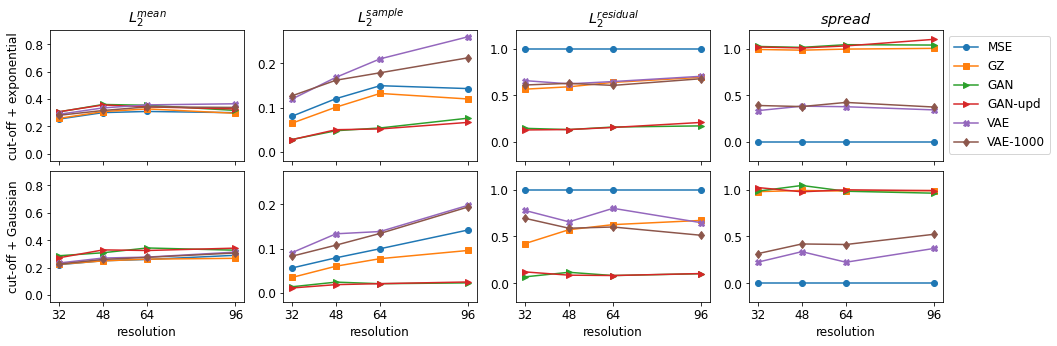

In [89]:
axs = plot_offline_metrics(dataset='offline_test.nc', models=['OLSModel', 'MeanVarModel', 'CGANRegression', 'CGANRegression-recompute', 'CVAERegression-None', 'CVAERegression-None-1000'], labels=['MSE', 'GZ', 'GAN', 'GAN-upd', 'VAE', 'VAE-1000'])
#plt.savefig('offline_VAE.pdf', bbox_inches='tight', pad_inches=0.1)

(0.0, 50.0)

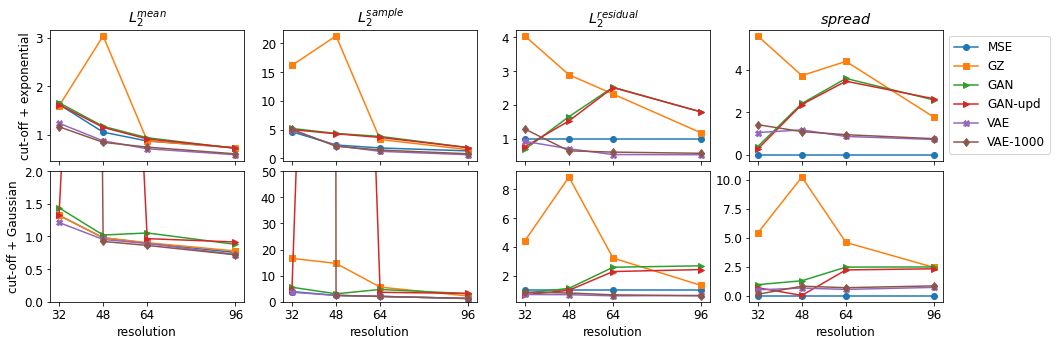

In [90]:
axs = plot_offline_metrics(dataset='offline_transfer.nc', models=['OLSModel', 'MeanVarModel', 'CGANRegression', 'CGANRegression-recompute', 'CVAERegression-None', 'CVAERegression-None-1000'], labels=['MSE', 'GZ', 'GAN', 'GAN-upd', 'VAE', 'VAE-1000'])
axs[1][0].set_ylim([0,2])
axs[1][1].set_ylim([0,50])
#plt.savefig('offline_VAE_transfer.pdf', bbox_inches='tight', pad_inches=0.1)

In [172]:
operator = 'Operator2'
resolution=64
lev=0
vae = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+operator+'-'+str(resolution)+'/CVAERegression-None/offline_test.nc').isel(lev=lev)
mse = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+operator+'-'+str(resolution)+'/OLSModel/offline_test.nc').isel(lev=lev)
gz = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+operator+'-'+str(resolution)+'/MeanVarModel/offline_test.nc').isel(lev=lev)
gan = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+operator+'-'+str(resolution)+'/CGANRegression/offline_test.nc').isel(lev=lev)

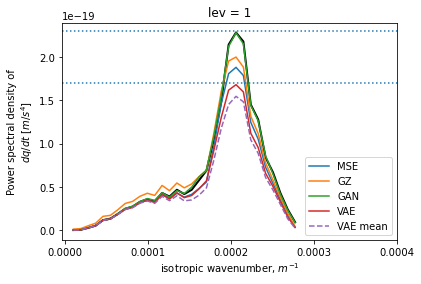

In [176]:
mse.PSD.plot(color='k', lw=2)
mse.PSD_gen.plot(label='MSE')
gz.PSD_gen.plot(label='GZ')
#gz.PSD_mean.plot(label='GZ mean', ls ='--')
#gz.PSD_gen_res.plot(label='GZ res', ls ='-.')
gan.PSD_gen.plot(label='GAN')
#gan.PSD_mean.plot(label='GAN mean', ls='--')
#gan.PSD_gen_res.plot(label='GAN res', ls ='-.')
vae.PSD_gen.plot(label='VAE')
vae.PSD_mean.plot(label='VAE mean', ls='--')
#vae.PSD_gen_res.plot(label='VAE res', ls ='-.')
plt.legend()
plt.xticks([0, 1e-4, 2e-4, 3e-4, 4e-4])
plt.axhline(y=1.7e-19, ls=':')
plt.axhline(y=2.3e-19, ls=':')
plt.savefig('spectrum_vae.pdf', bbox_inches='tight', pad_inches=0.1)

# Reduced amplitude

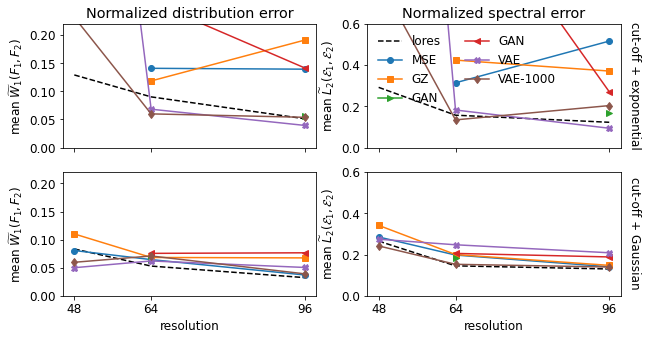

In [21]:
ax = plot_difference(normalize=False, model_weight=0.5, models=['Reference','OLSModel', 'MeanVarModel', 'CGANRegression', 'CGANRegression-recompute', 'CVAERegression-None', 'CVAERegression-None-1000'], labels=['lores', 'MSE', 'GZ', 'GAN', 'GAN', 'VAE', 'VAE-1000'], sampling='constant-0', configuration='jet')
plt.savefig('paper_figures/amplitude/amp_jet_0_5.pdf', bbox_inches='tight', pad_inches=0.1)

2 ['MSE', 'VAE']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_3600_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CVAERegression-None/eddy-constant-0/[0-9].nc


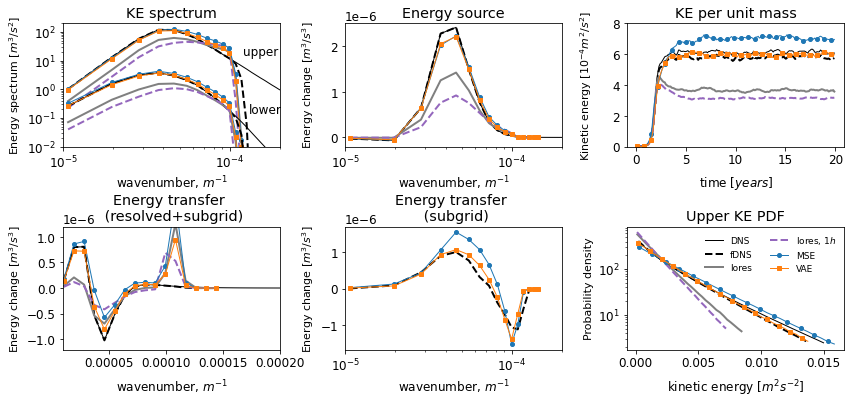

In [137]:
ax = plot_panel_figure(density='PDF_KE1', operator='Operator1', resolution=48, configuration='eddy', models_folders=['OLSModel', 'CVAERegression-None'], labels=['MSE', 'VAE'], samplings = 'constant-0');
ax[1][0].set_xscale('linear')
plt.savefig('plot.pdf', bbox_inches='tight', pad_inches=0.1)

In [139]:
difference['Operator1-48/OLSModel/eddy-constant-0']

{'distrib_diff_q1': 0.07869715753112345,
 'distrib_diff_q2': 0.025109940394816437,
 'distrib_diff_u1': 0.09898737916400949,
 'distrib_diff_u2': 0.08329611943303837,
 'distrib_diff_v1': 0.08155640858836082,
 'distrib_diff_v2': 0.07314018418385504,
 'distrib_diff_KE1': 0.1457841629159031,
 'distrib_diff_KE2': 0.1320130912758832,
 'distrib_diff_Ens1': 0.22054060515607773,
 'distrib_diff_Ens2': 0.15929704134225922,
 'spectral_diff_KEspec1': 0.26838872651249107,
 'spectral_diff_KEspec2': 0.18354058834197975,
 'spectral_diff_Eflux': 0.47372432535048387,
 'spectral_diff_APEgenspec': 0.10202341618043907}

In [140]:
difference['Operator1-48/CVAERegression-None/eddy-constant-0']

{'distrib_diff_q1': 0.015424746548146778,
 'distrib_diff_q2': 0.03410285288322308,
 'distrib_diff_u1': 0.021803250626116485,
 'distrib_diff_u2': 0.009037457298193554,
 'distrib_diff_v1': 0.016423772993894373,
 'distrib_diff_v2': 0.006197601493624041,
 'distrib_diff_KE1': 0.02358166816566981,
 'distrib_diff_KE2': 0.011896305740766316,
 'distrib_diff_Ens1': 0.06890973029263232,
 'distrib_diff_Ens2': 0.04389514665549361,
 'spectral_diff_KEspec1': 0.1292534205833807,
 'spectral_diff_KEspec2': 0.0678486847235779,
 'spectral_diff_Eflux': 0.2208038655503612,
 'spectral_diff_APEgenspec': 0.08585185888002662}

In [154]:
fdns = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc')
ols = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-0/[0-9].nc')
vae = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CVAERegression-None/eddy-constant-0/[0-9].nc')
for m in [ols, vae]:
    for var in ['KEspecr', 'Efluxr', 'APEgenspecr']:
        m[var+'_err'] = m[var] - fdns[var]

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CVAERegression-None/eddy-constant-0/[0-9].nc


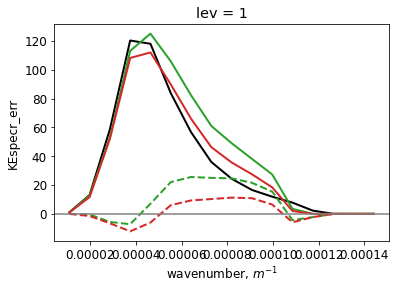

In [161]:
fdns.KEspecr.isel(lev=0).plot(color='k', lw=2, label='fDNS')
ols.KEspecr.isel(lev=0).plot(color='C2', lw=2)
ols.KEspecr_err.isel(lev=0).plot(color='C2', lw=2, ls='--', label='')
vae.KEspecr.isel(lev=0).plot(color='C3', lw=2)
vae.KEspecr_err.isel(lev=0).plot(color='C3', lw=2, ls='--')
plt.axhline(y=0, color='gray')

# Outliers on jet configuration in offline analysis?

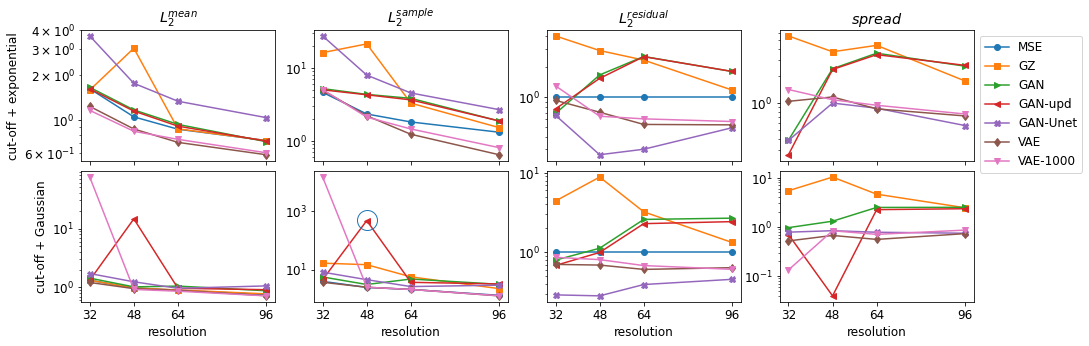

In [31]:
axs = plot_offline_metrics(dataset='offline_transfer.nc', models = ['OLSModel', 'MeanVarModel', 'CGANRegression', 'CGANRegression-recompute', 'CGANRegression-Unet', 'CVAERegression-None', 'CVAERegression-None-1000'], 
                           labels=['MSE', 'GZ', 'GAN', 'GAN-upd', 'GAN-Unet', 'VAE', 'VAE-1000'])
for i in range(2):
    for j in range(4):
        axs[i][j].set_yscale('log')
axs[1][1].plot(48, 500, marker='o', markersize=20, fillstyle='none')
#axs[1][1].plot(32, 20000, marker='o', markersize=20, fillstyle='none')
plt.savefig('paper_figures/outlier/metrics_offline.pdf', bbox_inches='tight', pad_inches=0.1)

In [118]:
operator='Operator1'
res = 48
offline_file = 'offline_transfer.nc'
folder = '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'
ds = {}
models = ['OLSModel', 'MeanVarModel', 'CGANRegression', 'CGANRegression-recompute', 'CGANRegression-Unet', 'CVAERegression-None', 'CVAERegression-None-1000']
for model in ['OLSModel', 'MeanVarModel', 'CGANRegression', 'CGANRegression-recompute', 'CGANRegression-Unet', 'CVAERegression-None', 'CVAERegression-None-1000']:
    file = os.path.join(folder, operator+'-'+str(res),model,offline_file)
    ds[model] = xr.open_dataset(file, decode_times=False)

In [37]:
def sel(x, run=2, time=-1, lev=0):
    return x.isel(run=run, time=time, lev=lev)

Text(0.5, 1.0, 'GAN-upd')

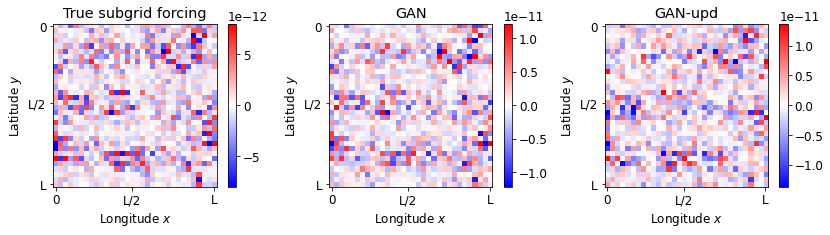

In [38]:
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
pse.imshow(sel(ds['OLSModel'].q_forcing_advection))
plt.title('True subgrid forcing')
plt.subplot(1,3,2)
pse.imshow(sel(ds['CGANRegression'].q_forcing_advection_gen))
plt.title('GAN')
plt.subplot(1,3,3)
pse.imshow(sel(ds['MeanVarModel'].q_forcing_advection_gen))
plt.title('GAN-upd')

In [62]:
def hormfuller(ds, var='q_forcing_advection', vmax1=5e-12, vmax2=5e-14):
    plt.figure(figsize=(8,4))
    plt.subplots_adjust(wspace=0.4)
    plt.subplot(1,2,1)
    ds[var].std(dim=('x', 'y')).isel(lev=0).plot(vmin=0, vmax=vmax1)
    plt.axhline(16)
    plt.axvline(1625)
    plt.subplot(1,2,2)
    ds[var].std(dim=('x', 'y')).isel(lev=1).plot(vmin=0, vmax=vmax2)
    plt.axhline(16)
    plt.axvline(1625)

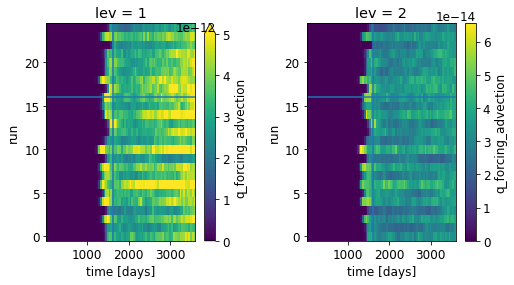

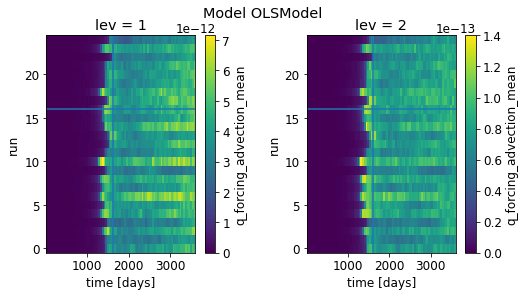

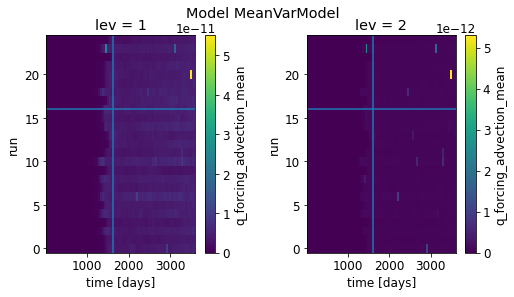

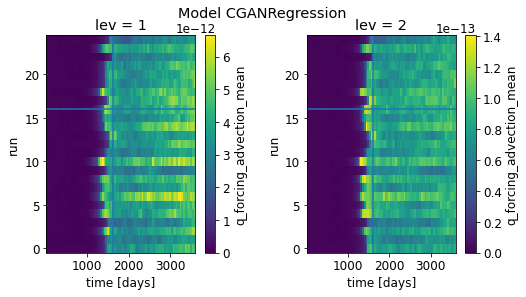

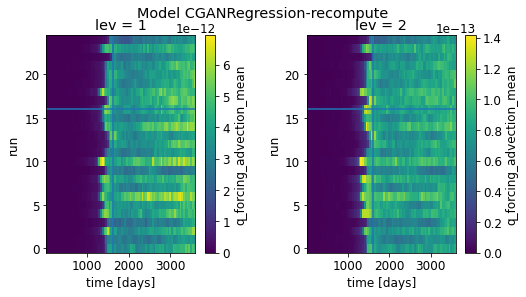

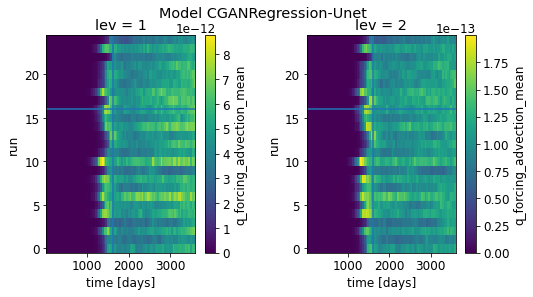

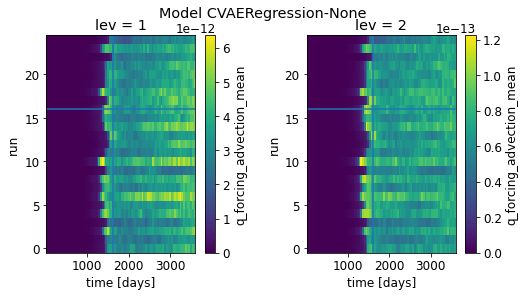

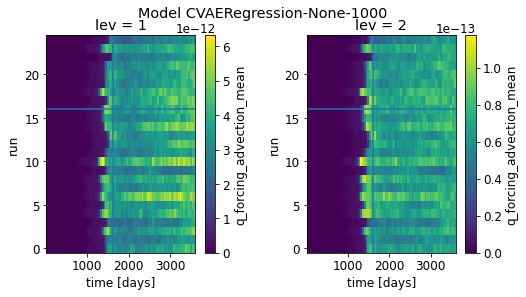

In [122]:
hormfuller(ds['OLSModel'], vmax2=None)
for model in models:
    hormfuller(ds[model], var='q_forcing_advection_mean', vmax1=None, vmax2=None)
    plt.suptitle(f'Model {model}')
#hormfuller(gan_upd, var='q_forcing_advection_gen')

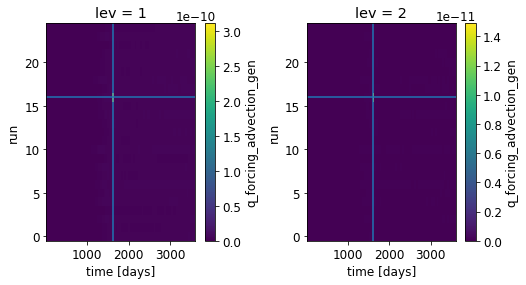

In [63]:
hormfuller(ds['CGANRegression-recompute'], var='q_forcing_advection_gen', vmax1=None, vmax2=None)
#plt.suptitle('Subgrid forcing std on jet dataset for GAN-upd', y=1.05)
#plt.savefig('paper_figures/outlier/jet_GAN_upd.pdf', bbox_inches='tight', pad_inches=0.1)

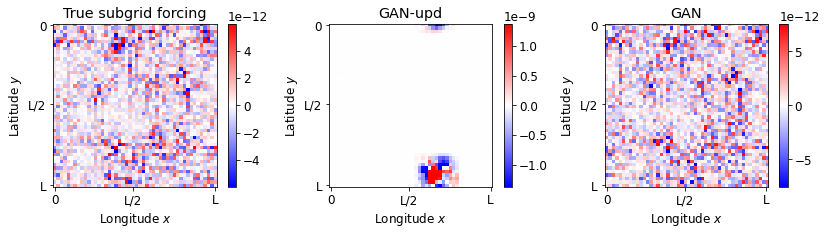

In [104]:
def sel(x, run=16, time=1625, lev=0):
    return x.sel(run=run, time=time).isel(lev=lev)

plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
pse.imshow(sel(ds['OLSModel'].q_forcing_advection))
plt.title('True subgrid forcing')
plt.subplot(1,3,2)
pse.imshow(sel(ds['CGANRegression-recompute'].q_forcing_advection_gen))
plt.title('GAN-upd')
plt.subplot(1,3,3)
pse.imshow(sel(ds['CGANRegression'].q_forcing_advection_gen))
plt.title('GAN')
plt.savefig('paper_figures/outlier/outlier_point_GAN_upd.pdf', bbox_inches='tight', pad_inches=0.1)

In [92]:
model = CGANRegression(nx=48, folder='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/CGANRegression-recompute/model')

reading CGANRegression from /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/CGANRegression-recompute/model


In [93]:
transfer_path = '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/Operator2-48/*.nc'
transfer = xr.open_mfdataset(transfer_path, combine='nested', concat_dim='run')

In [98]:
jet_offline = model.test_offline(transfer.isel(run=slice(16,17)))

Text(0.5, 1.0, 'GAN')

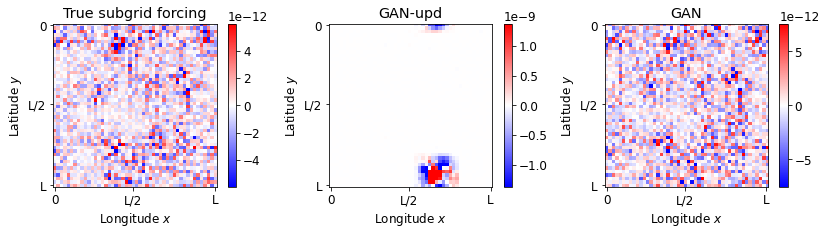

In [115]:
def sel(x, run=16, time=1625, lev=0):
    return x.sel(run=run, time=time).isel(lev=lev)

plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
pse.imshow(sel(ds['OLSModel'].q_forcing_advection))
plt.title('True subgrid forcing')
plt.subplot(1,3,2)
pse.imshow(jet_offline.q_forcing_advection_gen.isel(time=38, lev=0).squeeze())
plt.title('GAN-upd')
plt.subplot(1,3,3)
pse.imshow(sel(ds['CGANRegression'].q_forcing_advection_gen))
plt.title('GAN')
#plt.savefig('paper_figures/outlier/outlier_point_GAN_upd.pdf', bbox_inches='tight', pad_inches=0.1)

# How spectral error is improved

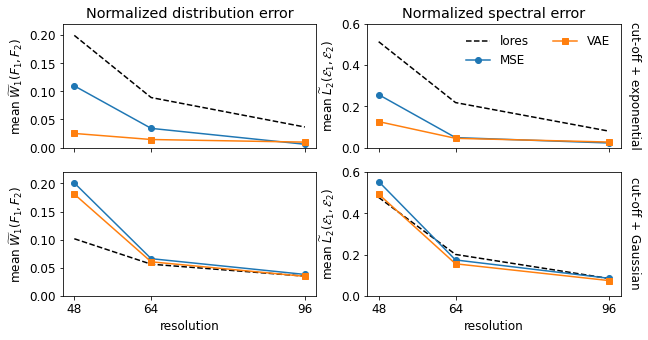

In [162]:
ax = plot_difference(normalize=False, models=['Reference','OLSModel', 'CVAERegression-None'], labels=['lores', 'MSE', 'VAE'], sampling='constant-0', configuration='eddy')

2 ['MSE', 'VAE']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_3600_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CVAERegression-None/eddy-constant-0/[0-9].nc


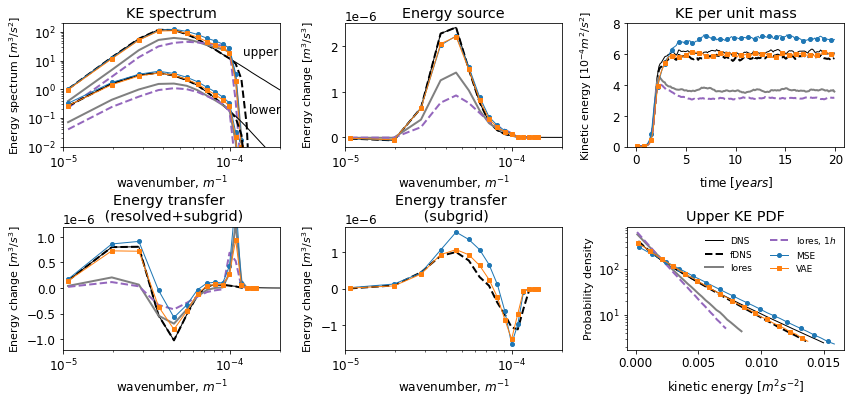

In [163]:
ax = plot_panel_figure(density='PDF_KE1', operator='Operator1', resolution=48, configuration='eddy', models_folders=['OLSModel', 'CVAERegression-None'], labels=['MSE', 'VAE'], samplings = 'constant-0');

In [168]:
fdns = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc')
ols = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-0/[0-9].nc')
vae = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CVAERegression-None/eddy-constant-0/[0-9].nc')
for m in [ols, vae]:
    for var in ['KEspecr', 'Efluxr', 'APEgenspecr']:
        m[var+'_err'] = np.abs(m[var] - fdns[var])

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CVAERegression-None/eddy-constant-0/[0-9].nc


[{0.26838872651249107, 'spectral_diff_KEspec1'}, {'spectral_diff_KEspec2', 0.18354058834197975}]
[{0.1292534205833807, 'spectral_diff_KEspec1'}, {'spectral_diff_KEspec2', 0.0678486847235779}]


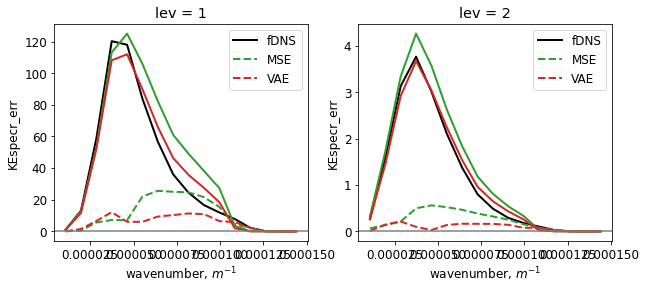

In [190]:
var = 'KEspecr'
plt.figure(figsize=(10,4))
if 'lev' in fdns[var].coords:
    for lev in [0,1]:
        plt.subplot(1,2,lev+1)
        fdns[var].isel(lev=lev).plot(color='k', lw=2, label='fDNS')
        ols[var].isel(lev=lev).plot(color='C2', lw=2)
        ols[var+'_err'].isel(lev=lev).plot(color='C2', lw=2, ls='--', label='MSE')
        vae[var].isel(lev=lev).plot(color='C3', lw=2)
        vae[var+'_err'].isel(lev=lev).plot(color='C3', lw=2, ls='--', label='VAE')
        plt.axhline(y=0, color='gray')
        plt.legend()
else:
    plt.subplot(1,2,1)
    fdns[var].plot(color='k', lw=2, label='fDNS')
    ols[var].plot(color='C2', lw=2)
    ols[var+'_err'].plot(color='C2', lw=2, ls='--', label='MSE')
    vae[var].plot(color='C3', lw=2)
    vae[var+'_err'].plot(color='C3', lw=2, ls='--', label='VAE')
    plt.axhline(y=0, color='gray')
    plt.legend()
    
print([{key, val} for key, val in difference['Operator1-48/OLSModel/eddy-constant-0'].items() if var[:-1] in key])
print([{key, val} for key, val in difference['Operator1-48/CVAERegression-None/eddy-constant-0'].items() if var[:-1] in key])

# How distribution error is improved

3 ['MSE', 'MSE $\\times 0.8$', 'MSE $\\times 0.5$']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_3600_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/0.8-eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/0.5-eddy-constant-0/[0-9].nc


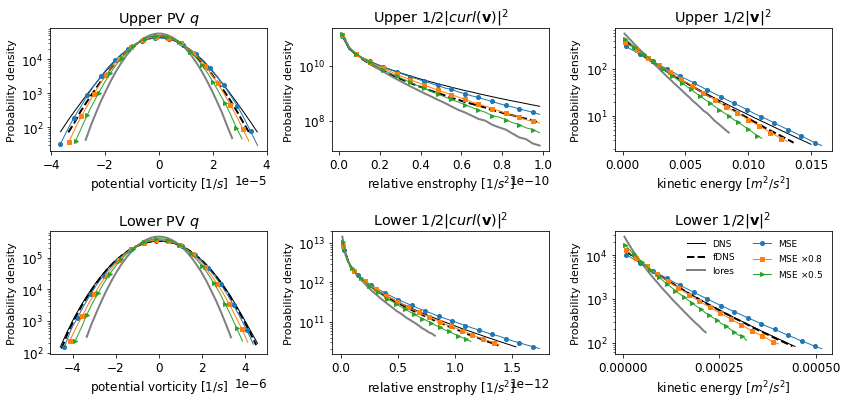

In [16]:
plot_PDFs(read_cache=True, operator='Operator1', models_weights=[1, 0.8, 0.5], labels=['MSE', 'MSE $\\times 0.8$', 'MSE $\\times 0.5$'], models_folders=['OLSModel', 'OLSModel', 'OLSModel']);
plt.savefig('sanity_pdf_mse.pdf', bbox_inches='tight', pad_inches=0.1)

3 ['GAN', 'GAN $\\times 0.8$', 'GAN $\\times 0.5$']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_3600_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/0.8-eddy-constant-0/[0-9].nc
Compute statistics
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/0.5-eddy-constant-0/[0-9].nc
Compute statistics


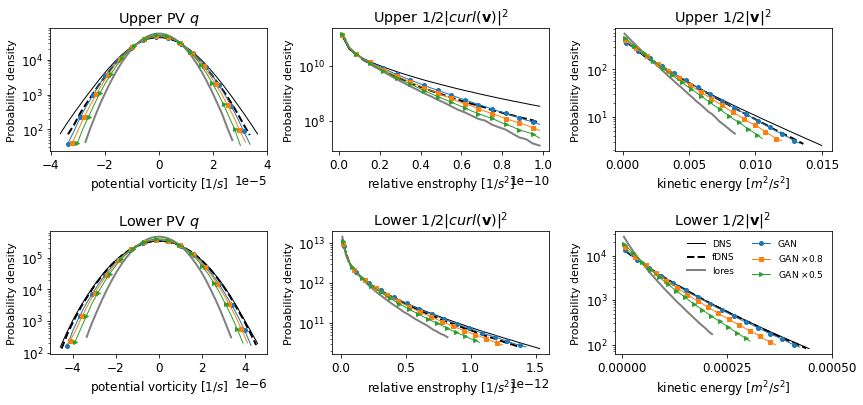

In [17]:
plot_PDFs(read_cache=True, operator='Operator1', models_weights=[1, 0.8, 0.5], labels=['GAN', 'GAN $\\times 0.8$', 'GAN $\\times 0.5$'], models_folders=3*['CGANRegression']);
plt.savefig('sanity_pdf_gan.pdf', bbox_inches='tight', pad_inches=0.1)

3 ['VAE', 'VAE $\\times 0.8$', 'VAE $\\times 0.5$']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_3600_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CVAERegression-None/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CVAERegression-None/0.8-eddy-constant-0/[0-9].nc
Compute statistics
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CVAERegression-None/0.5-eddy-constant-0/[0-9].nc


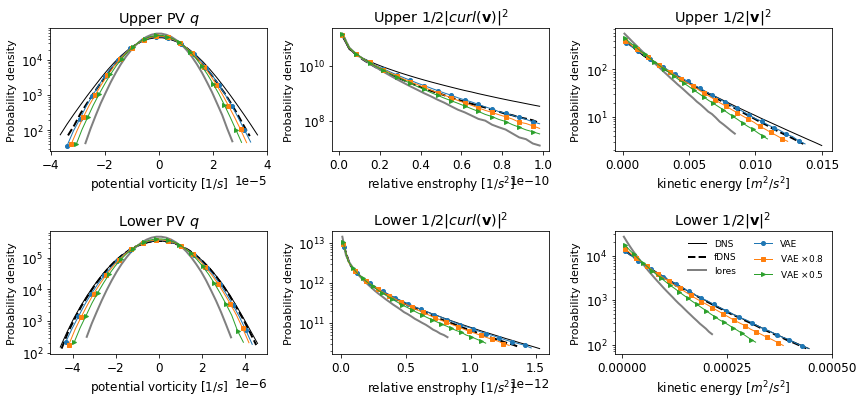

In [19]:
plot_PDFs(read_cache=True, operator='Operator1', models_weights=[1, 0.8, 0.5], labels=['VAE', 'VAE $\\times 0.8$', 'VAE $\\times 0.5$'], models_folders=3*['CVAERegression-None']);
plt.savefig('sanity_pdf_vae.pdf', bbox_inches='tight', pad_inches=0.1)

3 ['MSE', 'MSE $\\times 0.8$', 'MSE $\\times 0.5$']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_3600_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/0.8-eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/0.5-eddy-constant-0/[0-9].nc


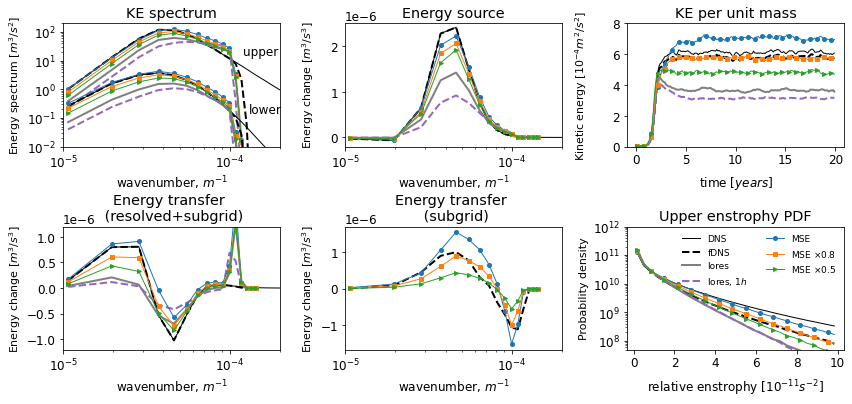

In [20]:
plot_panel_figure(read_cache=True, operator='Operator1', models_weights=[1, 0.8, 0.5], labels=['MSE', 'MSE $\\times 0.8$', 'MSE $\\times 0.5$'], models_folders=['OLSModel', 'OLSModel', 'OLSModel']);
plt.savefig('sanity_spectrum_mse.pdf', bbox_inches='tight', pad_inches=0.1)

3 ['GAN', 'GAN $\\times 0.8$', 'GAN $\\times 0.5$']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_3600_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/0.8-eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/0.5-eddy-constant-0/[0-9].nc


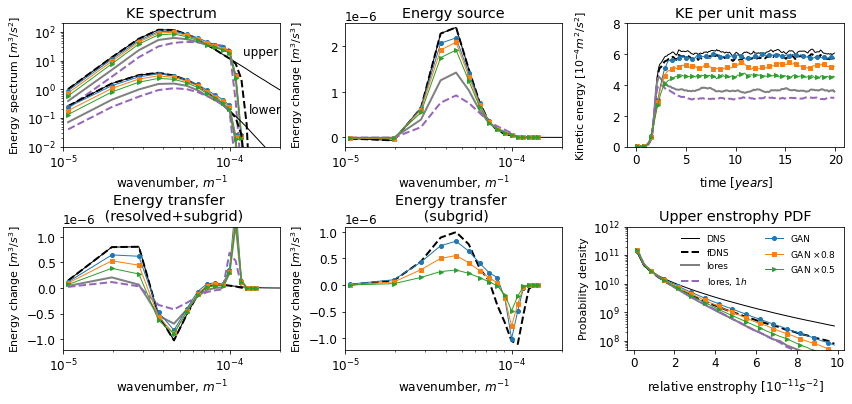

In [21]:
plot_panel_figure(read_cache=True, operator='Operator1', models_weights=[1, 0.8, 0.5], labels=['GAN', 'GAN $\\times 0.8$', 'GAN $\\times 0.5$'], models_folders=['CGANRegression']*3);
plt.savefig('sanity_spectrum_gan.pdf', bbox_inches='tight', pad_inches=0.1)

3 ['VAE', 'VAE $\\times 0.8$', 'VAE $\\times 0.5$']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_3600_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CVAERegression-None/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CVAERegression-None/0.8-eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CVAERegression-None/0.5-eddy-constant-0/[0-9].nc


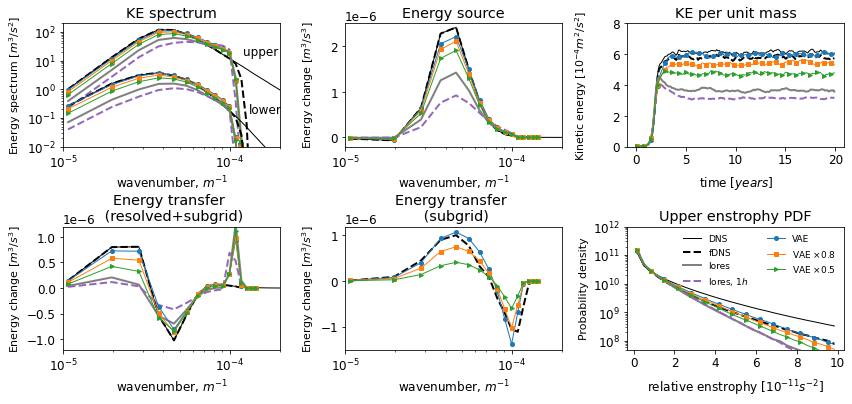

In [22]:
plot_panel_figure(read_cache=True, operator='Operator1', models_weights=[1, 0.8, 0.5], labels=['VAE', 'VAE $\\times 0.8$', 'VAE $\\times 0.5$'], models_folders=3*['CVAERegression-None']);
plt.savefig('sanity_spectrum_vae.pdf', bbox_inches='tight', pad_inches=0.1)

3 ['VAE', 'VAE $\\times 0.8$', 'VAE $\\times 0.5$']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_3600_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/CVAERegression-None/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/CVAERegression-None/0.8-eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/CVAERegression-None/0.5-eddy-constant-0/[0-9].nc


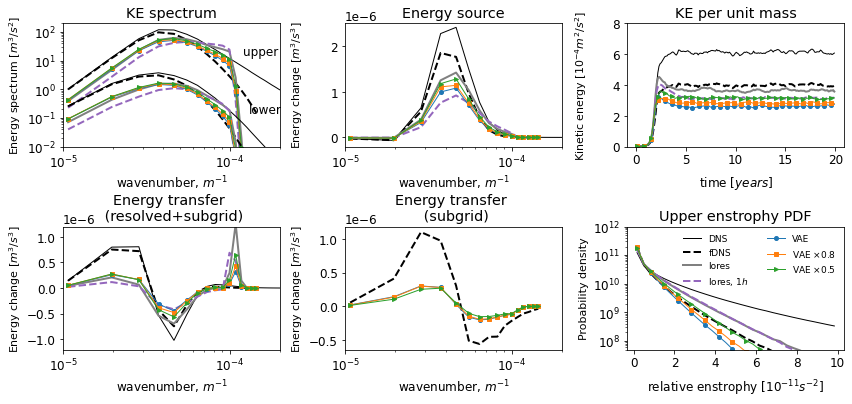

In [25]:
plot_panel_figure(read_cache=True, operator='Operator2', models_weights=[1, 0.8, 0.5], labels=['VAE', 'VAE $\\times 0.8$', 'VAE $\\times 0.5$'], models_folders=3*['CVAERegression-None']);
plt.savefig('sanity_spectrum_vae_op2.pdf', bbox_inches='tight', pad_inches=0.1)

3 ['GAN', 'GAN $\\times 0.8$', 'GAN $\\times 0.5$']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_3600_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/CGANRegression/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/CGANRegression/0.8-eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/CGANRegression/0.5-eddy-constant-0/[0-9].nc


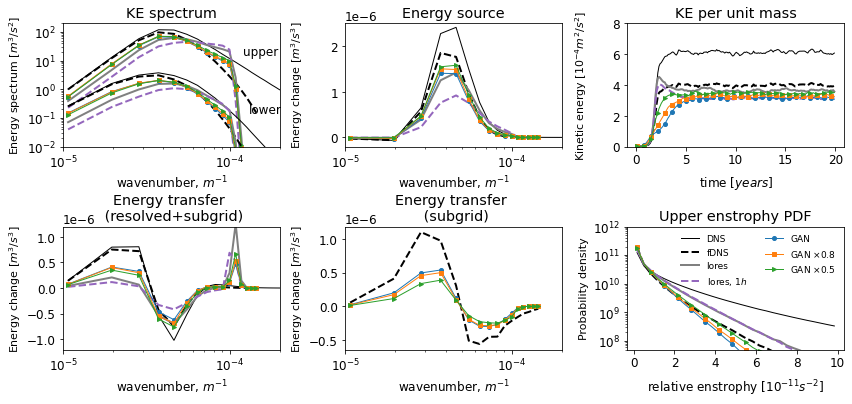

In [29]:
plot_panel_figure(read_cache=True, operator='Operator2', models_weights=[1, 0.8, 0.5], labels=['GAN', 'GAN $\\times 0.8$', 'GAN $\\times 0.5$'], models_folders=3*['CGANRegression']);
plt.savefig('sanity_spectrum_gan_op2.pdf', bbox_inches='tight', pad_inches=0.1)

3 ['MSE', 'MSE $\\times 0.8$', 'MSE $\\times 0.5$']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_3600_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/OLSModel/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/OLSModel/0.8-eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/OLSModel/0.5-eddy-constant-0/[0-9].nc


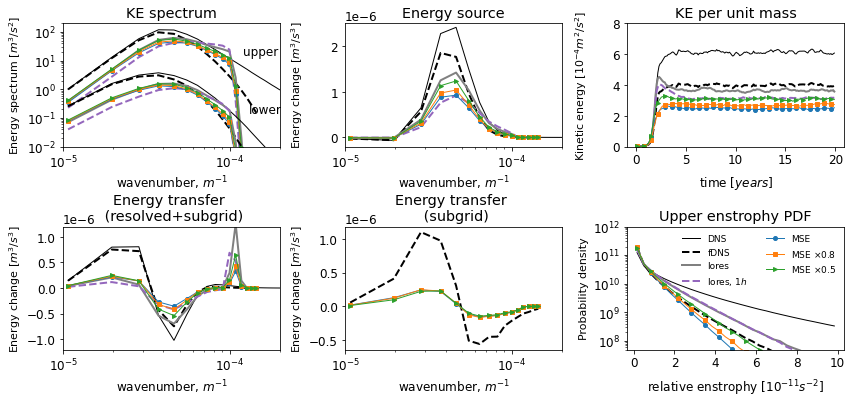

In [28]:
plot_panel_figure(read_cache=True, operator='Operator2', models_weights=[1, 0.8, 0.5], labels=['MSE', 'MSE $\\times 0.8$', 'MSE $\\times 0.5$'], models_folders=3*['OLSModel']);
plt.savefig('sanity_spectrum_mse_op2.pdf', bbox_inches='tight', pad_inches=0.1)

3 ['GZ', 'GZ $\\times 0.8$', 'GZ $\\times 0.5$']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_256/Operator2-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/jet/reference_3600_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/MeanVarModel/jet-3600-constant-0/[0-9].nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 6
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/MeanVarModel/0.8-jet-3600-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/MeanVarModel/0.5-jet-3600-constant-0/[0-9].nc


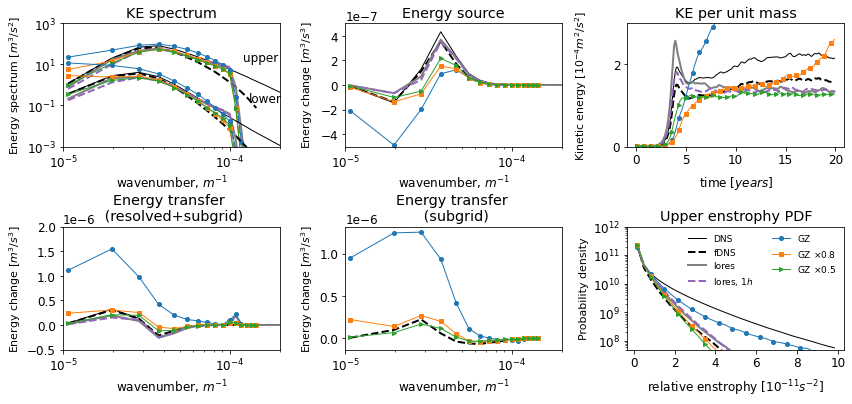

In [38]:
ax = plot_panel_figure(samplings='3600-constant-0', configuration='jet', operator='Operator2', models_weights=[1, 0.8, 0.5], labels=['GZ', 'GZ $\\times 0.8$', 'GZ $\\times 0.5$'], models_folders=3*['MeanVarModel']);
ax[0][2].set_ylim([0,3e-4])
ax[0][0].set_ylim([1e-3, 1e+3])
ax[0][1].set_ylim([-0.5e-6, 0.5e-6])
ax[1][0].set_ylim([-0.5e-6, 2e-6])
plt.savefig('sanity_check_jet.pdf', bbox_inches='tight', pad_inches=0.1)


# Decorrelation timescale 

In [81]:
def c_time(model, operator, resolution):
    model_file = xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(resolution)}/{model}/eddy-forecast/AR1-0/*.nc', combine='nested', concat_dim='run', decode_times=False)
    target_file = xr.open_dataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/{operator}-{str(resolution)}.nc', decode_times=False)
    line = xr.corr(model_file.q, target_file.q, dim=('x', 'y')).mean('run')
    vline = [np.max(line.time[line.isel(lev=lev)>0.5]).drop_vars('lev') for lev in [0,1]]
    for lev in [0,1]:
        T = vline[lev]
        vline[lev] += float((0.5 - line.sel(time=T).isel(lev=lev)) / (line.sel(time=T+1).isel(lev=lev) - line.sel(time=T).isel(lev=lev)))
    return line, vline

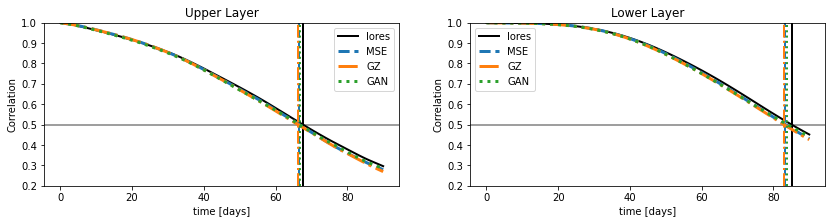

In [93]:
fig = plt.figure(figsize=(14,3))
for col in [0,1]:
    plt.subplot(1,2,col+1)
    plt.axhline(y=0.5, color='gray')
    
    line, vline = c_time('Reference', 'Operator1', 64)
    line.isel(lev=col).plot(color='k', lw=2, label='lores')
    plt.axvline(x=vline[col], color='k', lw=2)
    
    line, vline = c_time('OLSModel', 'Operator1', 64)
    line.isel(lev=col).plot(lw=3, ls='--', label='MSE')
    plt.axvline(x=vline[col], color='tab:blue', lw=2, ls='--')
    
    line, vline = c_time('MeanVarModel', 'Operator1', 64)
    line.isel(lev=col).plot(lw=3, ls='-.', label='GZ')
    plt.axvline(x=vline[col], color='tab:orange', lw=2, ls='-.')
    
    line, vline = c_time('CGANRegression', 'Operator1', 64)
    line.isel(lev=col).plot(lw=3, ls=':', label='GAN')
    plt.axvline(x=vline[col], color='tab:green', lw=2, ls=':')

    plt.legend()
    if col==0:
        plt.title('Upper Layer')
    elif col==1:
        plt.title('Lower Layer')
    plt.ylabel('Correlation')
    plt.ylim([0.2,1])
plt.savefig('Correlation.pdf', bbox_inches='tight', pad_inches=0.1)

# Decorrelation to compare with Andrew

In [6]:
 model = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/OLSModel/eddy-forecast/AR1-0/*.nc', combine='nested', concat_dim='run', decode_times=False)

In [22]:
target = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Default-256/Reference/eddy-forecast/Operator1-64.nc', decode_times=False)

In [46]:
corr = xr.corr(model.q, target.q, dim=('x', 'y', 'run'))
mse = ((model.q-target.q)**2).mean(dim=('x', 'y', 'run')) / ((target.q)**2).mean(dim=('x','y','run','time'))
rmse = np.sqrt(mse)

/ext3/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/ext3/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))


Text(0, 0.5, 'non-dimensional units')

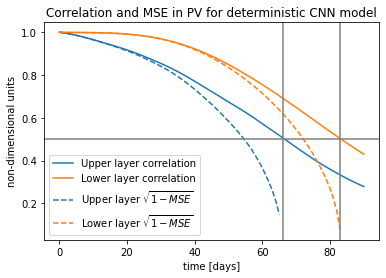

In [55]:
corr.isel(lev=0).plot(label='Upper layer correlation')
corr.isel(lev=1).plot(label='Lower layer correlation')
(np.sqrt(1-rmse**2)).isel(lev=0).plot(label='Upper layer $\sqrt{1-MSE}$', ls='--', color='C0')
(np.sqrt(1-rmse**2)).isel(lev=1).plot(label='Lower layer $\sqrt{1-MSE}$', ls='--', color='C1')
plt.axhline(y=0.5, color='gray')
plt.axvline(x=66, color='gray')
plt.axvline(x=83, color='gray')
plt.legend()
plt.title('Correlation and MSE in PV for deterministic CNN model')
plt.ylabel('non-dimensional units')

In [59]:
autocorr = xr.corr(target.q.isel(time=0), target.q, dim=('x','y','run'))

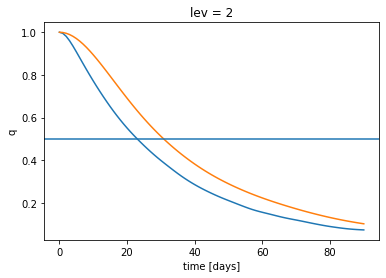

In [64]:
autocorr.isel(lev=0).plot()
autocorr.isel(lev=1).plot()
plt.axhline(y=0.5)

# INM talk

In [77]:
x = np.linspace(0,np.pi,100)
y = []
for xx in x:
    if xx < 2/3*np.pi:
        y.append(1.)
    else:
        y.append(np.exp(-23.6 * (xx - 2/3*np.pi)**4))
y = np.array(y)

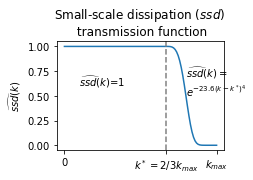

In [119]:
plt.figure(figsize=(3,2))
plt.plot(x,y)
plt.title('Small-scale dissipation ($ssd$) \n transmission function')
plt.xticks([0, 2/3*np.pi, np.pi], labels=[0, '$k^* = 2/3k_{max}$', '$k_{max}$'])
plt.axvline(x=2/3*np.pi, ls='--', color='gray')
plt.ylabel('$\widehat{ssd}(k)$')
plt.text(0.3, 0.6, '$\widehat{ssd}(k)$=1')
plt.text(2.5, 0.5, '$\widehat{ssd}(k)=$\n$e^{-23.6(k-k^*)^4}$')
plt.savefig('ssd.pdf', bbox_inches='tight', pad_inches=0.1)

1 ['MSE']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_3600_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/OLSModel/eddy-constant-0/[0-9].nc


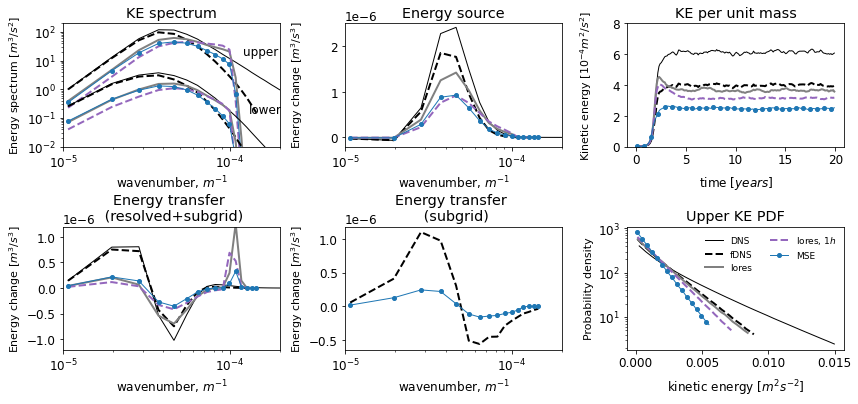

In [4]:
ax = plot_panel_figure(density='PDF_KE1', operator='Operator2', resolution=48, configuration='eddy', models_folders=['OLSModel'], labels=['MSE'], samplings = 'constant-0');
plt.savefig('INM/48op2.pdf', bbox_inches='tight', pad_inches=0.1)

3 ['CNN', 'GAN', 'VAE']
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_3600_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/OLSModel/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/CGANRegression/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/CVAERegression-None/eddy-constant-0/[0-9].nc


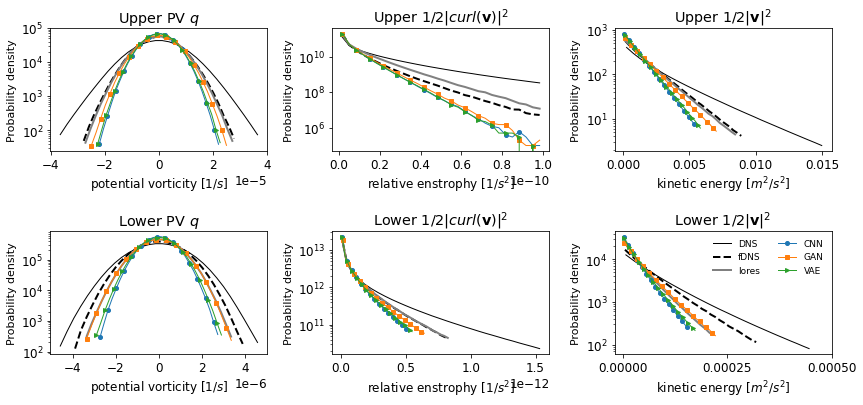

In [29]:
plot_PDFs(read_cache=True, markersizes=4, operator='Operator2', resolution=48, models_folders=['OLSModel', 'CGANRegression', 'CVAERegression-None'], labels=['CNN', 'GAN', 'VAE']);
plt.savefig('INM/48op2_PDF.pdf', bbox_inches='tight', pad_inches=0.1)

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CVAERegression-None/eddy-constant-0/[0-9].nc
0 0.014281714987009773
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
Warning! Computations are unstable. Number of files is less than 10 and equal to 1
/scratch/pp2681/pyqg_ge

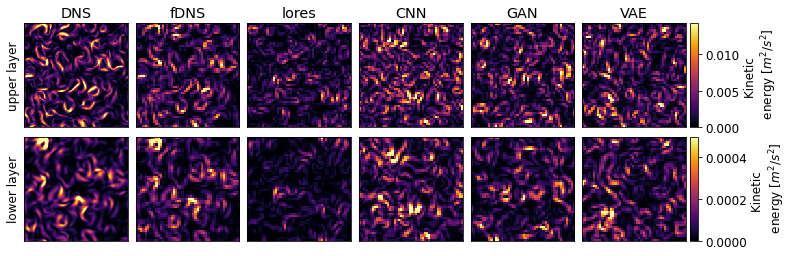

In [32]:
plot_solution(operator='Operator1', resolution=48, configuration='eddy', models_folders=['OLSModel', 'CGANRegression', 'CVAERegression-None'], labels=['CNN', 'GAN', 'VAE'])
plt.savefig('INM/snapshot_eddy.pdf', bbox_inches='tight', pad_inches=0.1)

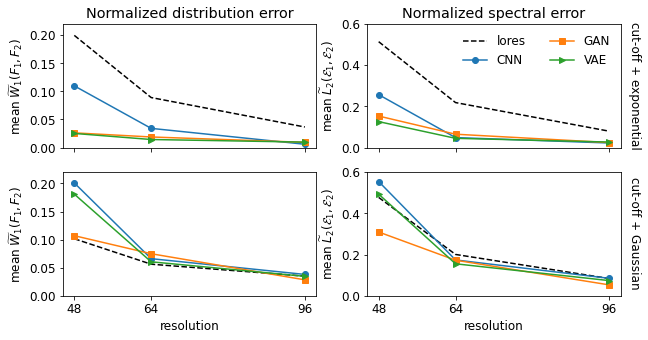

In [35]:
ax = plot_difference(normalize=False, models=['Reference','OLSModel', 'CGANRegression', 'CVAERegression-None'], labels=['lores', 'CNN', 'GAN', 'VAE'], sampling='constant-0', configuration='eddy')
plt.savefig('INM/distribution_error.pdf', bbox_inches='tight', pad_inches=0.1)

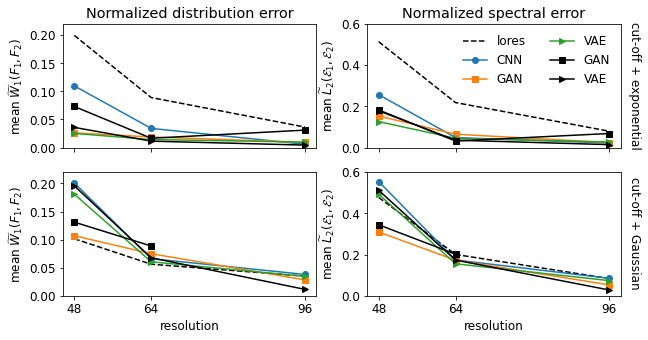

In [39]:
ax = plot_difference(normalize=False, colors=['k','C0', 'C1', 'C2', 'k', 'k'], markers=['','o','s','>','s','>'], models=['Reference','OLSModel', 'CGANRegression', 'CVAERegression-None', 'CGANRegression-recompute', 'CVAERegression-None-1000'], labels=['lores', 'CNN', 'GAN', 'VAE', 'GAN', 'VAE'], sampling='constant-0', configuration='eddy')
plt.savefig('INM/distribution_error_reproducible.pdf', bbox_inches='tight', pad_inches=0.1)